In [337]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf
import itertools
import math

## Movie data

movie.metadata.tsv.gz [3.4 M]
Metadata for 81,741 movies, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

In [338]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [339]:
movies.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [340]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


## Character data

character.metadata.tsv.gz [14 M]
Metadata for 450,669 characters aligned to the movies above, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:

- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

In [341]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
375004,4246248,/m/0bs490,1929-12-07,NaN,NaN,M,NaN,NaN,Norman Brokenshire,NaN,/m/05bfzyn,NaN,/m/05bfzy9
390823,58147,/m/0fy66,1962-10-24,Zilkov,1925-12-13,M,NaN,NaN,Albert Paulsen,36.0,/m/0h5vbj7,/m/0h5vbht,/m/027nxcx
413566,23991829,/m/07kgy9y,2010,NaN,1988-04-16,NaN,NaN,NaN,Katy Marie Johnson,21.0,/m/0h4nrrz,NaN,/m/0h4nrs2
370721,4326127,/m/0bx8nm,2006-08-25,German Messenger,1976-04-04,M,1.78,NaN,James Roday,30.0,/m/0cg4ls7,/m/0h38pdl,/m/0f0f90
202016,23919719,/m/076vxx2,1947,NaN,1921-03-28,M,1.74,NaN,Dirk Bogarde,25.0,/m/0gg2cp5,NaN,/m/0151xv


Let's map the wikipedia_movie_id to the movie name given in movies 'name' column

In [342]:
characters = characters.merge(movies[['wikipedia_id','name']], how='left', left_on='wikipedia_movie_id', right_on='wikipedia_id')
characters.drop('wikipedia_id', inplace=True, axis=1)

In [343]:
characters.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Ghosts of Mars
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Ghosts of Mars
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,Ghosts of Mars
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Ghosts of Mars


## Official IMDb dataset

This dataset includes all IMDb data. https://www.imdb.com/interfaces/

title.basics.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
 - primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
 - originalTitle (string) - original title, in the original language
 - isAdult (boolean) - 0: non-adult title; 1: adult title
 - startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
 - endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
 - runtimeMinutes – primary runtime of the title, in minutes
 - genres (string array) – includes up to three genres associated with the title

title.ratings.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - averageRating – weighted average of all the individual user ratings
 - numVotes - number of votes the title has received

title.crew.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - directors (array of nconsts) - director(s) of the given title
 - writers (array of nconsts) – writer(s) of the given title

name.basics.tsv.gz: information of actors
 - nconst (string) - alphanumeric unique identifier of the name/person
 - primaryName (string)– name by which the person is most often credited
 - birthYear – in YYYY format
 - deathYear – in YYYY format if applicable, else '\N'
 - primaryProfession (array of strings)– the top-3 professions of the person
 - knownForTitles (array of tconsts) – titles the person is known for

In [344]:
imdb_titles = pd.read_csv('./data/imdb/imdb_titles.tsv', na_values='\\N', sep='\t')
imdb_ratings = pd.read_csv('./data/imdb/imdb_ratings.tsv', na_values='\\N', sep='\t')
imdb_crew = pd.read_csv('./data/imdb/imdb_crew.tsv', na_values='\\N', sep='\t')
imdb_people = pd.read_csv('./data/imdb/imdb_people.tsv', na_values='\\N', sep='\t')

In [345]:
imdb_titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short"


In [346]:
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1923
1,tt0000002,5.8,260
2,tt0000003,6.5,1738
3,tt0000004,5.6,175
4,tt0000005,6.2,2553


In [347]:
imdb_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


In [348]:
imdb_people.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0071877,tt0037382,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0054452,tt0049189,tt0057345,tt0056404"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"


In [349]:
imdb_people.describe()

,birthYear,deathYear
count,568354.000000,208794.000000
mean,1952.249489,1991.615310
std,34.844203,34.748459
min,4.000000,17.000000
25%,1931.000000,1978.000000
50%,1959.000000,2000.000000
75%,1978.000000,2013.000000
max,2022.000000,2022.000000


## IMDB budget data:

This dataset includes the ratings for 3828 IMDB movies. 
source: https://github.com/jeremy-lee93/dsc-mod-1-project-v2-1-onl01-dtsc-pt-052620/blob/master/IMDb_budgets.csv

- Movie:  Title of movie
- Year: Movie release year
- IMDb: IMDB rating over 10
- Rating: Certificate
- Runtime [min]
- Genre
- Release Date: Movie release date
- Production Budget: Budget spent for production of the movie
- Domestic Gross: Gross revenue in US and Canada for all time
- Worldwide Gross: Worldwide gross revenue for all time

In [350]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [351]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
2490,The Postman,1997,6.1,R,177,"Action, Adventure, Drama","Dec 25, 1997",80000000,17650704,20841123
2882,The Astronaut's Wife,1999,5.4,R,109,"Drama, Sci-Fi, Thriller","Aug 27, 1999",34000000,10672566,10672566
875,Captain Underpants: The First Epic Movie,2017,6.2,PG,89,"Animation, Action, Comedy","Jun 2, 2017",38000000,73921000,126577874
3367,Happiness,1998,7.7,Unrated,134,"Comedy, Drama","Oct 16, 1998",3000000,2746453,5746453
2922,The Walk,2015,7.3,PG,123,"Adventure, Biography, Drama","Sep 30, 2015",35000000,10161183,61492104


In [352]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


## Wikipedia

Wikipedia page views statistics
source: this data is crowed from the wikimedia API by the ./utils/wikipedia_pageview_statistics.py script
    
- `name`: Title of a movie
- `pageviews`: Number of page views for a movie with a `name`. The value is an weighted aggregation for the pageviews for the period between 01/12/2021 and 30/11/2022. The weight is computed with this formula - `weight = 1 + ((2022 - movie_release_year) / (2022 - min_movie_year))`. The aggregation is accomplished by the `mean` function.

In [353]:
wikipedia_pageviews = pd.read_csv('./handled_data/movies_wikipedia_pageviews.csv')

In [354]:
wikipedia_pageviews.sample(5)

,name,pageviews
3579,Anokha Pyar,366.650198
10641,Die ideale Frau,0.193137
3573,Anny – Story of a Prostitute,23.005435
42140,The Password is Courage,12.358366
34644,Sometimes In April,7.287055


# Cleaning & Pre-processing of data

In [355]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [356]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [357]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [358]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [359]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [360]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [361]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [362]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [363]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [364]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [365]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [366]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [367]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [368]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

A very important characteristic describing the characters is their ethnicity. In the original dataset only the freebase id referring to the ethnicity was available. Thus, a script that can be found in `utils/ethnicities_freebase_ids_script.py` has been created to relate it to the actual labels (p.e. '/m/0152s7' stands for 'Anglo-Irish people'). A CSV has been created to map the ids and the labels, it can be found in `handled_data/ethnicities_freebase_ids.csv`. This is how it looks like:Add ethnicity labels using the freebase ethnicity ids

In [369]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv')
ethnicity_freebase_ids.head(5)

,ethnicity_freebase_id,ethnicity_label
0,/m/01267,Albanians
1,/m/012c1l,French Canadians
2,/m/012f86,Ukrainians
3,/m/012fh,Afrikaners
4,/m/01336l,Asian Americans


As it can be seen, the ethnicities are extremely specific and it is very difficult to extract some conclusions. Therefore, we grouped all ethnicities that are repeated more than 10 times into five main ethnic groups: Asian, Black, Latino, Indian and White. This classification can be found in the CSV document in `handled_data/major_ethnicities_clustering.csv`. This is how it looks like:

In [370]:
major_ethnicities = pd.read_csv('handled_data/major_ethnicities_clustering.csv',sep=',');
major_ethnicities.head(10)

,ethnicity_label,major_ethnicity
0,African Americans,Black
1,American Jews,White
2,Americans,White
3,Argentines,Latino
4,Ashkenazi Jews,White
5,Asian Americans,Asian
6,Asian people,Asian
7,Australians,White
8,Austrians,White
9,Bengali people,Indian


Next step is to merge this two tables into the characters main dataframe

In [371]:
characters = pd.merge(characters, ethnicity_freebase_ids, how='left', left_on='actor_ethnicity_freebase_id', right_on='ethnicity_freebase_id')
characters.drop('ethnicity_freebase_id', inplace=True, axis=1)
characters = pd.merge(characters, major_ethnicities, how='left', on='ethnicity_label')

Finally, this the characters main data frame in which we are working

In [372]:
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name,ethnicity_label,major_ethnicity
219739,17275536,/m/0crtg4c,1973,NaN,NaN,NaN,NaN,NaN,Malka Ribowska,NaN,/m/0gc7q6m,NaN,/m/0bz76ws,Two Men in Town,NaN,NaN
380266,1989045,/m/06c805,2002-10-25,NaN,1975-02-07,M,NaN,NaN,Dan Green,27.0,/m/0k1zv8,NaN,/m/075npt,Pokémon 4Ever,NaN,NaN
423310,9337317,/m/0285294,1931,NaN,1904-07-10,F,1.6,NaN,Lili Damita,26.0,/m/02vcy_5,NaN,/m/031g6h,Fighting Caravans,NaN,NaN
357999,16139940,/m/03wb3t_,1925-09-06,NaN,1887-11-09,F,1.7,NaN,Gertrude Astor,NaN,/m/04m62cy,NaN,/m/0d1bn2,Kentucky Pride,NaN,NaN
69795,21405990,/m/05f6k0g,NaN,NaN,NaN,M,NaN,NaN,Uttam Mohanty,NaN,/m/05nw6tc,NaN,/m/06zqqv,Mu Tate Love Karuchi,NaN,NaN


In [373]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.536250e+05,157666.000000,294959.000000
mean,1.393780e+07,1.747917,37.925895
std,1.079782e+07,0.106067,14.096938
min,3.300000e+02,0.610000,0.000000
25%,3.738820e+06,1.676400,28.000000
50%,1.180718e+07,1.750000,36.000000
75%,2.362455e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [374]:
def split_list(df, column_name, sep=','):
    df[column_name] = df[column_name].replace(np.nan, '').apply(lambda x: x.split(sep))

In [375]:
def fill_na_with_list(df, column_name):
    df[column_name] = df[column_name].fillna('').apply(list)

In [376]:
split_list(imdb_crew, 'directors')
split_list(imdb_crew, 'writers')
split_list(imdb_titles, 'genres')

In [377]:
imdb_people_dict = dict(zip(imdb_people['nconst'], imdb_people['primaryName']))

In [378]:
imdb_crew['directors'] = imdb_crew['directors'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [379]:
imdb_crew['writers'] = imdb_crew['writers'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [380]:
imdb = pd.merge(pd.merge(imdb_titles, imdb_ratings, how='inner', on='tconst'), imdb_crew, how='inner', on='tconst')

In [381]:
# Free memory
del imdb_titles
del imdb_ratings
del imdb_crew

In [382]:
imdb.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
903846,tt2933648,tvEpisode,Episode #1.49,Episode #1.49,0,2012.0,NaN,50.0,"[Drama, Mystery, Romance]",8.3,7,[Joana Jabace],[]
360836,tt0729659,tvEpisode,The Legacy Begins,The Legacy Begins,0,2002.0,NaN,45.0,"[Adventure, Comedy, Reality-TV]",7.1,339,"[Brian Klein, Richard Heeley, Chris Hooke, Sim...",[]
1068907,tt5667474,movie,The Birth of Narcissus,La naissance de Narcisse,0,2018.0,NaN,88.0,"[Drama, Mystery, Sci-Fi]",6.1,7,[Hugo Parthonnaud],[Hugo Parthonnaud]
414000,tt0886222,tvEpisode,Deathblow,Deathblow,0,1998.0,NaN,26.0,"[Action, Adventure, Animation]",7.6,199,[Thomas A. Nelson],"[Rebekah Bradford Leekley, Gerard Brown, John ..."
691813,tt15344582,tvEpisode,"2014-2018, Hayaller ve Gerçekler","2014-2018, Hayaller ve Gerçekler",0,2021.0,NaN,NaN,[Drama],8.3,51,[Cem Karci],[Hakan Bonomo]


In [383]:
imdb.describe()

,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes
count,1.253452e+06,1.253191e+06,41948.000000,901787.000000,1.253452e+06,1.253452e+06
mean,1.551795e-02,2.001829e+03,2005.704777,56.207179,6.952086e+00,1.041908e+03
std,1.236008e-01,2.125113e+01,15.357264,96.507384,1.388000e+00,1.729051e+04
min,0.000000e+00,1.874000e+03,1933.000000,0.000000,1.000000e+00,5.000000e+00
25%,0.000000e+00,1.995000e+03,1998.000000,23.000000,6.200000e+00,1.200000e+01
50%,0.000000e+00,2.009000e+03,2011.000000,45.000000,7.100000e+00,2.600000e+01
75%,0.000000e+00,2.016000e+03,2018.000000,86.000000,7.900000e+00,1.010000e+02
max,1.000000e+00,2.022000e+03,2024.000000,51420.000000,1.000000e+01,2.667015e+06


### Weighted IMDB rating

To estimate a movie success, we need to both account for the rating 'averageRating' and to the correponding number of votes 'numVotes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

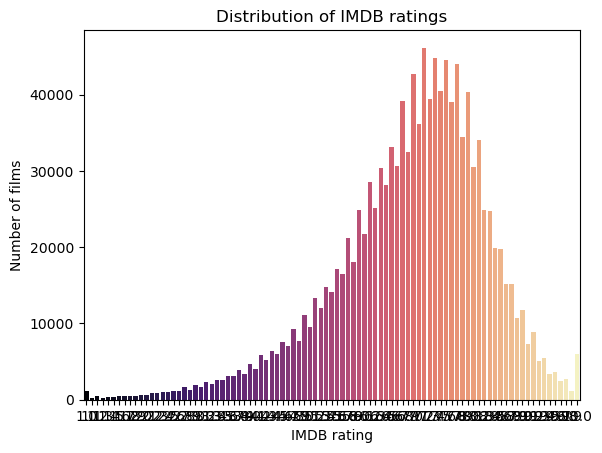

In [384]:
_ = sns.countplot(x='averageRating', data=imdb, palette="magma") \
   .set(title='Distribution of IMDB ratings', xlabel='IMDB rating', ylabel='Number of films')

In [385]:
C = imdb['averageRating'].mean()
m = imdb['numVotes'].min()
v = imdb['numVotes']
R = imdb['averageRating']

In [386]:
imdb['WR'] = (v / (v + m)) * R + (m / (v + m)) * C # Complete original dataset


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [387]:
imdb[['originalTitle', 'averageRating', 'WR', 'numVotes']].sort_values('WR', ascending=False).head()

,originalTitle,averageRating,WR,numVotes
853340,Ozymandias,10.0,9.999918,185650
1000173,Unbreakable Souls,10.0,9.993245,2251
1023521,Angels Apocalypse,10.0,9.992627,2062
749029,Final Draft,10.0,9.978922,718
308511,Episode #1.9,10.0,9.975694,622


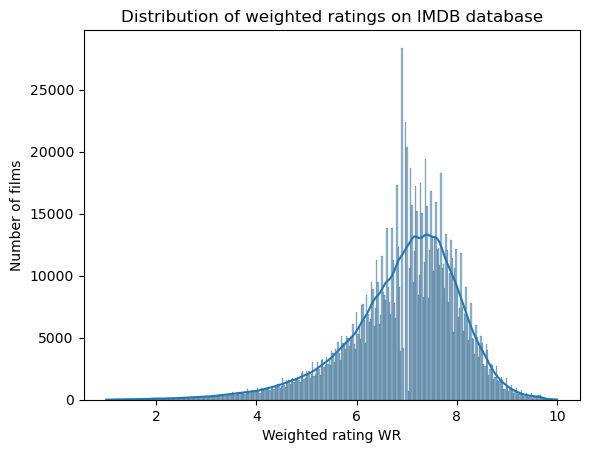

In [388]:
_ = sns.histplot(x='WR', data=imdb, kde=True) \
   .set(title='Distribution of weighted ratings on IMDB database', xlabel='Weighted rating WR', ylabel='Number of films')

### Merge IMDB database with movie database to have common features

We would like to merge the data from CMU movies and IMDB top 1000. Since we don't want to reduce the size of data, we would rather to an outer merge and fill missing values with NaN.

In [389]:
len((imdb['originalTitle'] + imdb['startYear'].astype(str)).unique()) / len(imdb)

0.9297141015371949

In [390]:
imdb.drop_duplicates(subset=['originalTitle', 'startYear'], inplace=True)

In [391]:
len((movies['name'] + movies['release_year'].astype(str)).unique()) / len(movies)

0.9977122863679182

In [392]:
# Remove duplicated movie with video game
movies.drop(movies[movies['wikipedia_id'] == 3184269].index, inplace=True)
# Fix duplicated movie with changing it release year to the correct one based on its wikipedia page
movies.loc[movies['wikipedia_id'] == 25357930, ['release_year']] = "2010"

In [393]:
movies.drop_duplicates(subset=['name', 'release_year'], inplace=True)

In [394]:
imdb.rename({'originalTitle': 'name', 'startYear': 'release_year'}, axis=1, inplace=True)

In [395]:
movies['release_year'] = movies['release_year'].replace('nan', np.nan).astype('float32')
movies['release_month'] = movies['release_month'].replace('nan', np.nan).astype('float32')
movies['release_day'] = movies['release_day'].replace('nan', np.nan).astype('float32')

In [396]:
movie_feature = movies.merge(imdb, on=['name', 'release_year'], how='left')

In [397]:
# Free memory
del imdb
del movies

In [398]:
def fill_NaN(df, column_left, column_right, column_name=None): # Updates missing data from left column with right column data
    if column_name is None:
        column_name = column_left
    df[column_name] = df[column_left].fillna(df[column_right])

In [399]:
fill_NaN(movie_feature, 'runtime', 'runtimeMinutes')
fill_NaN(movie_feature, 'genres_x', 'genres_y', 'genre')
movie_feature.drop(labels=['runtimeMinutes', 'genres_x', 'genres_y', 'primaryTitle', 'titleType', 'tconst', 'endYear'], axis=1, inplace=True)

In [400]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

In [401]:
movie_feature.sample(3)

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,release_year,release_month,release_day,isAdult,averageRating,numVotes,directors,writers,WR,genre
51068,14186169,/m/07t724c,Oldest Living Confederate Widow Tells All,NaN,240.0,NaN,[United States of America],1994.0,NaN,NaN,0.0,7.1,556.0,[Ken Cameron],"[Joyce Eliason, Allan Gurganus]",7.098682,"[Biography, Television movie, Americana, Perio..."
44752,4795269,/m/0cnnrm,My Little Pony: The Princess Promenade,NaN,71.0,[English],[United States of America],2006.0,2.0,7.0,0.0,7.5,4773.0,[Victor Dal Chele],"[Jeanne Romano, Bonnie Zacherle]",7.499427,"[Children's, Animation, Family-Oriented Advent..."
38176,16643469,/m/03yj9gx,Judge Priest,NaN,80.0,[English],[United States of America],1934.0,NaN,NaN,0.0,6.2,2296.0,[John Ford],"[Irvin S. Cobb, Dudley Nichols, Lamar Trotti]",6.201634,"[Crime Fiction, Comedy of manners, Black-and-w..."


In [402]:
movie_feature.describe()

,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day,isAdult,averageRating,numVotes,WR
count,8.155500e+04,8.392000e+03,67052.000000,74720.000000,42596.000000,39305.000000,44031.000000,44031.000000,4.403100e+04,44031.000000
mean,1.740360e+07,4.799791e+07,93.715766,1977.460815,6.692201,15.651240,0.002566,6.195617,1.378128e+04,6.224498
std,1.098688e+07,1.122099e+08,60.342111,29.101585,3.483220,8.715734,0.050595,1.155310,7.286329e+04,1.102334
min,3.300000e+02,1.000000e+04,0.000000,1010.000000,1.000000,1.000000,0.000000,1.000000,5.000000e+00,1.131770
25%,7.320728e+06,2.075232e+06,80.000000,1956.000000,4.000000,8.000000,0.000000,5.600000,1.070000e+02,5.614247
50%,1.777503e+07,1.063551e+07,93.000000,1985.000000,7.000000,16.000000,0.000000,6.300000,5.160000e+02,6.317251
75%,2.714269e+07,4.073253e+07,108.000000,2004.000000,10.000000,23.000000,0.000000,7.000000,2.660500e+03,6.998635
max,3.750192e+07,2.782275e+09,5700.000000,2016.000000,12.000000,31.000000,1.000000,10.000000,2.667015e+06,9.467126


In [403]:
# print(f'There are {(imdb.shape[0]+movies.shape[0]) - movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


In [404]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

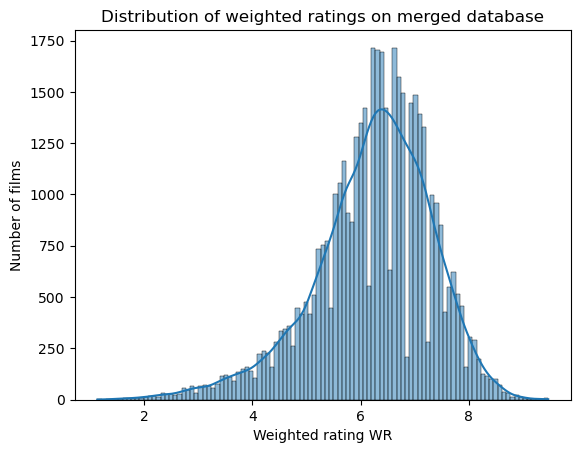

In [405]:
sns.histplot(x='WR', data=movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


In [406]:
len((movie_feature['name'] + movie_feature['release_year'].astype(str)).unique()) / len(movie_feature)

1.0

### Fill missing budget data from imdb budget dataset

In [407]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
1532,Widows,2018,6.9,R,129,"Crime, Drama, Thriller","Nov 9, 2018",40000000,42402632,73866088
2538,Norm of the North,2016,3.4,PG,90,"Animation, Adventure, Comedy","Jan 14, 2016",18000000,17062499,30535660
3624,Eye See You,2002,5.3,R,96,"Crime, Thriller","Sep 20, 2002",55000000,79161,1807990
1595,Legion,2010,5.2,R,100,"Action, Fantasy, Horror","Jan 22, 2010",26000000,40168080,67647574
3799,Force 10 from Navarone,1978,6.4,PG,118,"Action, Drama, War","Dec 22, 1978",5000000,7100000,7100000


In [408]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date

In [409]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('float32')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('float32')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('float32')

In [410]:
imdb_budget.drop(['Year', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [411]:
imdb_budget['genres'] = imdb_budget['genres'].apply(lambda el: el.split(', '))

In [412]:
imdb_budget.describe()

,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08,2003.593994,7.322100,15.891066
std,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08,12.767752,3.378486,8.437509
min,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [413]:
len((movie_feature['name'] + str(movie_feature['release_year'])).unique()) / len(movie_feature)

0.9254858684323463

In [414]:
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [415]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

In [416]:
movie_feature_with_budget = movie_feature.merge(imdb_budget, on=['name', 'release_year'], how='outer')

In [417]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y'],
      dtype='object')

In [418]:
fill_NaN(movie_feature_with_budget,'genre','genres','genre')
fill_NaN(movie_feature_with_budget,'release_day_x','release_day_y','release_day')
fill_NaN(movie_feature_with_budget,'release_month_x','release_month_y','release_month')
fill_NaN(movie_feature_with_budget,'runtime','Runtime')

### Investigate the gross difference between the original and the imdb budget datasets

<AxesSubplot:title={'center':'Distribution of the difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

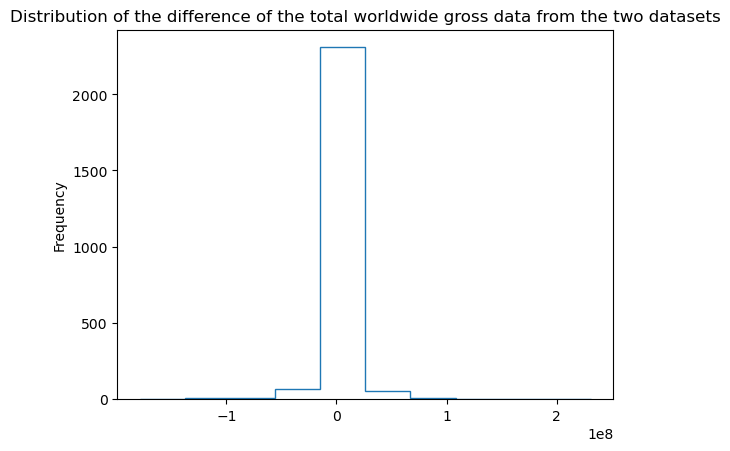

In [419]:
(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']).plot(kind='hist', histtype='step', title='Distribution of the difference of the total worldwide gross data from the two datasets')

<AxesSubplot:title={'center':'Distribution of the percentage in difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

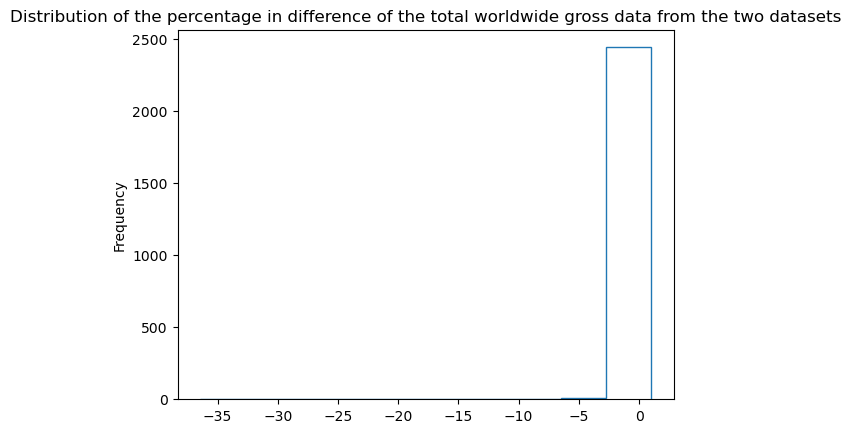

In [420]:
((movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']).plot(kind='hist', histtype='step', title='Distribution of the percentage in difference of the total worldwide gross data from the two datasets')

In [421]:
movie_feature_with_budget_differences = movie_feature_with_budget.copy()
movie_feature_with_budget_differences['gross_difference'] = np.abs(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'])
movie_feature_with_budget_differences['gross_difference%'] = ((np.abs(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']) * 100).round(2)

In [422]:
# Difference between the total worldwide gross data from the two datasets
movie_feature_with_budget_differences \
    [(movie_feature_with_budget_differences['gross_difference'] != 0) & (~movie_feature_with_budget_differences['gross_difference'].isna())] \
    .sort_values('gross_difference%', ascending=False) \
    [['name', 'box_office_revenue', 'Worldwide Gross', 'gross_difference', 'gross_difference%']]

,name,box_office_revenue,Worldwide Gross,gross_difference,gross_difference%
1611,The Son of No One,30680.0,1148578.0,1117898.0,3643.74
10379,Restless,163265.0,2772511.0,2609246.0,1598.17
3307,Welcome to Collinwood,336620.0,4606284.0,4269664.0,1268.39
30129,Margaret,46495.0,623292.0,576797.0,1240.56
4126,The Wizard of Oz,3017000.0,34949482.0,31932482.0,1058.42
...,...,...,...,...,...
56979,Click,237681299.0,237685089.0,3790.0,0.00
57636,G-Force,292810686.0,292817841.0,7155.0,0.00
12989,What Women Want,374111707.0,374105123.0,6584.0,0.00
58624,Butch Cassidy and the Sundance Kid,102308889.0,102310653.0,1764.0,0.00


In [423]:
# Percentage differences between the gross data from the two datasets
movie_feature_with_budget_differences.describe(percentiles=[.25, .5, .75, .8, .9, .95])[['gross_difference%']]

,gross_difference%
count,2464.000000
mean,16.458888
std,101.443043
min,0.000000
25%,0.020000
50%,0.695000
75%,5.455000
80%,9.924000
90%,34.167000
95%,62.882000


In [424]:
movie_feature_with_budget_differences[movie_feature_with_budget_differences['gross_difference'] == 0].shape[0] / movie_feature_with_budget_differences['gross_difference%'].notna().sum()

0.15868506493506493

In [425]:
movie_feature_with_budget_differences[
    (movie_feature_with_budget_differences['name'] == 'The Son of No One') |
    (movie_feature_with_budget_differences['name'] == 'Restless') |
    (movie_feature_with_budget_differences['name'] == 'Welcome to Collinwood')
][[
    'name', 'box_office_revenue', 'Worldwide Gross'
]]

,name,box_office_revenue,Worldwide Gross
1611,The Son of No One,30680.0,1148578.0
3307,Welcome to Collinwood,336620.0,4606284.0
10379,Restless,163265.0,2772511.0
18706,Restless,NaN,NaN
31576,Restless,NaN,NaN


In [426]:
# gross_difference = box_office_revenue - Worldwide Gross
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] > 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] < 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] == 0).sum())
(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross']).describe()

1012
1061
391


count    2.464000e+03
mean     4.148700e+05
std      1.570988e+07
min     -1.785914e+08
25%     -6.153875e+05
50%      0.000000e+00
75%      1.997022e+05
max      2.310745e+08
dtype: float64

We want to fill the missing data from the imdb budget dataset. For this purpose we are comparing the difference between the CMU, imdb top 1000, and imdb budget data. We have the:
 
 * `box_office_revenue` - from CMU with 8401 values /total gross/
 * `Gross` - from imdb top 1000 with 831 values /total gross in US and Canada/
 * `Domestic Gross` - from imdb budget with 3841 values /total gross in US and Canada/
 * `Worldwide Gross` - from imdb budget with 3841 values /total gross/

We would only consider the total worldwide gross since we are investigating movies from the whole world. The information for it is contained in the `box_office_revenue` and `Worldwide Gross`. Only around 20% of the values for the total gross are the same. Also, we know that the other data in `box_office_revenue` is not bigger or smaller than the `Worldwide Gross` for all records. So we can conclude that `box_office_revenue` and `Worldwide Gross` are not connected.

Based on this, we cannot combine the data from the both datasets and we would prefer using the data from the imdb budget dataset because it contains information about the budget of the movie and the data inside seams more accurate based on the comparison of a subset of it with Wikipedia data.

In [427]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [428]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [429]:
# Remove merged extra columns 
movie_feature_with_budget.drop([
    'Worldwide Gross', 'Domestic Gross', 'Rating', 'Runtime', 'IMDb', 'release_month_x', 'release_month_y',
    'release_day_x', 'release_day_y', 'genres'
], axis=1, inplace=True)

# Rename gross column
movie_feature_with_budget.rename({'box_office_revenue': 'total_gross'}, axis=1, inplace=True)

# Compute profit as success indicator
movie_feature_with_budget['profit'] = movie_feature_with_budget['total_gross'] - movie_feature_with_budget['Production Budget']

In [430]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'total_gross', 'runtime',
       'languages', 'countries', 'release_year', 'isAdult', 'averageRating',
       'numVotes', 'directors', 'writers', 'WR', 'genre', 'Production Budget',
       'release_day', 'release_month', 'profit'],
      dtype='object')

In [431]:
movie_feature_with_budget.describe()

,wikipedia_id,total_gross,runtime,release_year,isAdult,averageRating,numVotes,WR,Production Budget,release_day,release_month,profit
count,8.155500e+04,8.392000e+03,68104.000000,75770.000000,44031.000000,44031.000000,4.403100e+04,44031.000000,3.828000e+03,40527.000000,43783.000000,2.464000e+03
mean,1.740360e+07,4.799791e+07,93.965487,1977.970337,0.002566,6.195617,1.378128e+04,6.224498,4.030960e+07,15.658129,6.707717,7.208180e+07
std,1.098688e+07,1.122099e+08,59.949382,29.228281,0.050595,1.155310,7.286329e+04,1.102334,4.480927e+07,8.708538,3.483055,1.442546e+08
min,3.300000e+02,1.000000e+04,0.000000,1010.000000,0.000000,1.000000,5.000000e+00,1.131770,7.000000e+03,1.000000,1.000000,-1.110072e+08
25%,7.320728e+06,2.075232e+06,80.000000,1956.000000,0.000000,5.600000,1.070000e+02,5.614247,1.100000e+07,8.000000,4.000000,4.951632e+05
50%,1.777503e+07,1.063551e+07,93.000000,1986.000000,0.000000,6.300000,5.160000e+02,6.317251,2.500000e+07,16.000000,7.000000,2.414130e+07
75%,2.714269e+07,4.073253e+07,108.000000,2004.000000,0.000000,7.000000,2.660500e+03,6.998635,5.000000e+07,23.000000,10.000000,8.700518e+07
max,3.750192e+07,2.782275e+09,5700.000000,2020.000000,1.000000,10.000000,2.667015e+06,9.467126,4.000000e+08,31.000000,12.000000,2.545275e+09


In [432]:
movie_feature_with_budget.head(5)

,wikipedia_id,freebase_id,name,total_gross,runtime,languages,countries,release_year,isAdult,averageRating,numVotes,directors,writers,WR,genre,Production Budget,release_day,release_month,profit
0,975900.0,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001.0,0.0,4.9,55353.0,[John Carpenter],"[Larry Sulkis, John Carpenter]",4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,24.0,8.0,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,16.0,2.0,NaN
2,28463795.0,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],1988.0,0.0,5.7,40.0,[Sølve Skagen],"[Sølve Skagen, Gunnar Staalesen]",5.839121,"[Crime Fiction, Drama]",NaN,NaN,NaN,NaN
3,9363483.0,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],1987.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Thriller, Erotic thriller, Psychological thri...",NaN,NaN,NaN,NaN
4,261236.0,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],1983.0,NaN,NaN,NaN,NaN,NaN,NaN,[Drama],NaN,NaN,NaN,NaN


## Account for inflation: 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate.

Source: https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp

In [433]:
# Create dictionary of cumulative inflation rate per decade since 1913 in the US:
inflation_rates = [92.86, 4.82, -18.6, 68.57, 24.58, 28.23, 103.45, 64.41, 33.47, 28.31, 19.38, 1.27]
inflation_rates = [x / 100 + 1 for x in inflation_rates]
decades = list(np.linspace(1913,2023,len(inflation_rates)))
inflation_dic = dict(map(lambda i,j : (i,j) , decades, inflation_rates))

In [434]:
df = movie_feature_with_budget.copy()

In [435]:
# Initialisation
df['profit_modified'] = df['profit']
df['total_gross_modified'] = df['total_gross']
df['budget_modified'] = df['Production Budget']

In [436]:
for k in range(len(decades)-1): # For each decade
    year_before = decades[k]
    year = decades[k+1]
    inflation_rate = inflation_dic[year_before]
    
    decade_df = df[(df['release_year']<year) & (df['release_year']>year_before)] # decade mask
    
    idx = decade_df.index.tolist()

    # Create new column with prices modified by interest rate
    df.loc[idx, 'profit_modified'] = decade_df['profit'] * inflation_rate
    df.loc[idx, 'total_gross_modified'] = decade_df['total_gross'] * inflation_rate
    df.loc[idx, 'budget_modified'] = decade_df['Production Budget'] * inflation_rate

In [437]:
movie_feature_with_budget = df.copy()

In [438]:
movie_feature_with_budget.head(2)

,wikipedia_id,freebase_id,name,total_gross,runtime,languages,countries,release_year,isAdult,averageRating,...,writers,WR,genre,Production Budget,release_day,release_month,profit,profit_modified,total_gross_modified,budget_modified
0,975900.0,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001.0,0.0,4.9,...,"[Larry Sulkis, John Carpenter]",4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,24.0,8.0,NaN,NaN,1.870026e+07,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000.0,NaN,NaN,...,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,16.0,2.0,NaN,NaN,NaN,NaN


In [439]:
# Delete the columns for budget which are not modified by inflation rate: 
movie_feature_with_budget.drop(['total_gross','profit', 'Production Budget'], axis=1, inplace=True)

### Wikipedia pageviews

In [440]:
wikipedia_pageviews.sample(5)

,name,pageviews
45279,Throne of Blood,12952.024704
37282,The Bawdy Adventures of Tom Jones,562.106061
19465,Just Like the Son,149.324111
12325,Emmanuelle 5: A Time to Dream,441.554677
27212,Night Mail,1492.028656


In [441]:
wikipedia_pageviews.describe()

,pageviews
count,45819.000000
mean,2396.190760
std,10343.997960
min,0.000000
25%,46.054842
50%,230.307230
75%,1041.628953
max,410868.409091


In [442]:
movie_feature_with_budget_and_wikipedia_pageviews = pd.merge(movie_feature_with_budget, wikipedia_pageviews, on='name', how='left')

# Free memory
del movie_feature_with_budget
del wikipedia_pageviews

In [443]:
movie_feature_with_budget_and_wikipedia_pageviews.describe()

,wikipedia_id,runtime,release_year,isAdult,averageRating,numVotes,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
count,8.155500e+04,68104.000000,75770.000000,44031.000000,44031.000000,4.403100e+04,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,46823.000000
mean,1.740360e+07,93.965487,1977.970337,0.002566,6.195617,1.378128e+04,6.224498,15.658129,6.707717,9.605612e+07,6.483874e+07,5.092346e+07,2734.818491
std,1.098688e+07,59.949382,29.228281,0.050595,1.155310,7.286329e+04,1.102334,8.708538,3.483055,1.897343e+08,1.487117e+08,5.505716e+07,11517.211493
min,3.300000e+02,0.000000,1010.000000,0.000000,1.000000,5.000000e+00,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000
25%,7.320728e+06,80.000000,1956.000000,0.000000,5.600000,1.070000e+02,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,47.083004
50%,1.777503e+07,93.000000,1986.000000,0.000000,6.300000,5.160000e+02,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,238.284585
75%,2.714269e+07,108.000000,2004.000000,0.000000,7.000000,2.660500e+03,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1094.704134
max,3.750192e+07,5700.000000,2020.000000,1.000000,10.000000,2.667015e+06,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,410868.409091


### Prepare `df_all`

In [444]:
# For simplicity of use, we rename the dataframe
df_all = movie_feature_with_budget_and_wikipedia_pageviews

#### Deal with NaN

In [445]:
fill_na_with_list(df_all, 'languages')
fill_na_with_list(df_all, 'countries')
fill_na_with_list(df_all, 'genre')
fill_na_with_list(df_all, 'directors')
fill_na_with_list(df_all, 'writers')

#### Remove irrelevant columns

In [446]:
df_all.drop(['wikipedia_id', 'averageRating', 'numVotes'], axis=1, inplace=True)

# Exploratory Data Analysis

## Success indicators

Success of a movie can be very subjective. We thus need to diversify our definitions of success to have a holistic view of our dataset. The following success indicators are considered: 
- How well a movie is received: 
    IMDB ratings which should be weighted by the number of votes
- How profitable a movie is: 
    Overall gross revenue of the movie OR profit = gross revenue - budget spent
- How long a movie will last in time: 
    Number of connection to the movie wikipedia page


## Explore data

Looking at the impacts of features on eachother by drawing a correlation heatmap

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_5729/2314911968.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


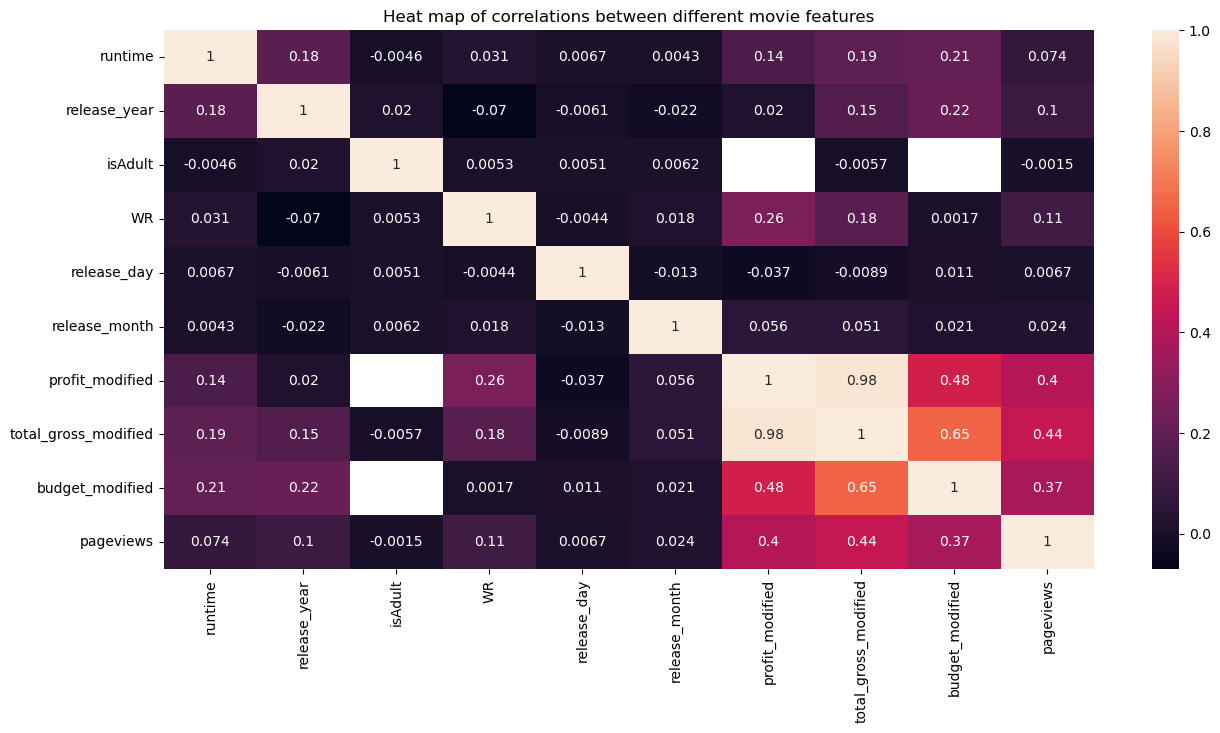

In [447]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


Interesting correlations: 
Our different success indicators are not too correlated (WR, profit_modified, pageviews) 

### Creation of unique success score

In order to investigate the relation between movie features and success, it would be practical to have a unique movie success score. Seeing how the weighted ratings, the profit, and the number of pageviews are uncorrelated, a movie that is successful in time (high pageviews) might however not be the most profitable (high profit), same thing for IMDB rating. 

In [448]:
# We standardise each success feature
df_all['WR_std'] = (df_all['WR'] - df_all['WR'].mean())/df_all['WR'].std()
df_all['profit_modified_std'] = (df_all['profit_modified'] - df_all['profit_modified'].mean())/df_all['profit_modified'].std()
df_all['pageviews_std'] = (df_all['pageviews'] - df_all['pageviews'].mean())/df_all['pageviews'].std()
df_all['total_gross_modified_std'] = (df_all['total_gross_modified'] - df_all['total_gross_modified'].mean())/df_all['total_gross_modified'].std()



In [449]:
# We L2 normalise each success feature
df_all['WR_norm'] = df_all['WR'] / np.sqrt(np.square(df_all['WR']).sum(axis=0))
df_all['profit_modified_norm'] = df_all['profit_modified'] / np.sqrt(np.square(df_all['profit_modified']).sum(axis=0))
df_all['pageviews_norm'] = df_all['pageviews'] / np.sqrt(np.square(df_all['pageviews']).sum(axis=0))
df_all['total_gross_modified_norm'] = df_all['total_gross_modified'] / np.sqrt(np.square(df_all['total_gross_modified']).sum(axis=0))



In [450]:
df_all[['WR_std','profit_modified_std','pageviews_std','WR_norm','profit_modified_norm','pageviews_norm']].describe()

,WR_std,profit_modified_std,pageviews_std,WR_norm,profit_modified_norm,pageviews_norm
count,4.403100e+04,2.464000e+03,4.682300e+04,44031.000000,2464.000000,46823.000000
mean,-3.255706e-16,-6.488316e-18,-1.214006e-18,0.004693,0.009101,0.001068
std,1.000000e+00,1.000000e+00,1.000000e+00,0.000831,0.017976,0.004496
min,-4.619948e+00,-1.256965e+00,-2.374549e-01,0.000853,-0.013495,0.000000
25%,-5.535986e-01,-5.027024e-01,-2.333669e-01,0.004233,0.000064,0.000018
50%,8.414206e-02,-3.343836e-01,-2.167655e-01,0.004763,0.003090,0.000093
75%,7.022702e-01,1.030759e-01,-1.424055e-01,0.005276,0.010954,0.000427
max,2.941601e+00,1.670645e+01,3.543684e+01,0.007137,0.309422,0.160405


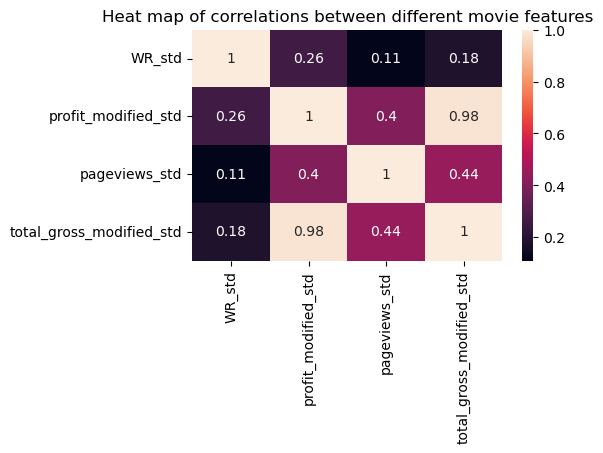

In [451]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_all[['WR_std','profit_modified_std','pageviews_std','total_gross_modified_std']].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

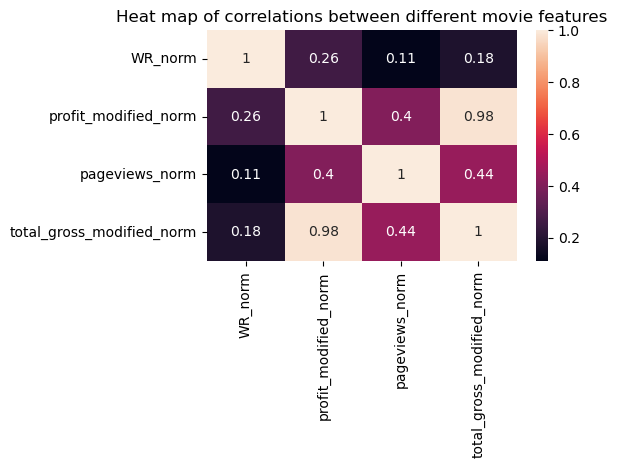

In [452]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_all[['WR_norm','profit_modified_norm','pageviews_norm','total_gross_modified_norm']].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

There is still no strong correlations between success features. This indicates that the different scores are independent. Therefore, we create a single movie score based on the rank of each movie for individual scores. The best movie according to each individual feature will thus be ranked with score 1.

In [453]:
# Drop columns since unused 
df_all.drop(['WR_std','profit_modified_std','pageviews_std','WR_norm','profit_modified_norm','pageviews_norm'],axis=1,inplace=True)

In [454]:
# Rating of movies according to feature 1: WR : Score 1 'S1'
df_all.sort_values(by='WR',ascending=False,inplace=True)
df_all['S1'] = np.arange(1, len(df_all)+1)

# Rating of movies according to feature 2: profit_modified : Score 2 'S2'
df_all.sort_values(by='profit_modified',ascending=False,inplace=True)
df_all['S2'] = np.arange(1, len(df_all)+1)

# Rating of movies according to feature 3: total_gross_modified : Score 3 'S3'
df_all.sort_values(by='total_gross_modified',ascending=False,inplace=True)
df_all['S3'] = np.arange(1, len(df_all)+1)

# Rating of movies according to feature 4: pageviews : Score 4 'S4'
df_all.sort_values(by='pageviews',ascending=False,inplace=True)
df_all['S4'] = np.arange(1, len(df_all)+1)

# Number of movies: 
N_movies = len(df_all)

To make sure the movie i single rank is not redundant with rank of movie j , we create a score by taking the best (weighted minimum) of the three ranks. 

In [455]:
r1 = df_all['S1'][0]
r2 = df_all['S2'][0]
r3 = df_all['S3'][0]
r4 = df_all['S4'][0]

R1 = {r1, r2, r3, r4}
R2 = R1 - {min(R1)} # Remove min R1
R3 = R1 - {min(R1), min(R2)}
R4 = R1 - {min(R1), min(R2), min(R3)}

print(r1,r2,r3,r4)

39158 39322 3824 1786


In [456]:
score = min(R1) * 2**(3 * math.log2(N_movies) + 1) + min(R2) * 2**(2 * math.log2(N_movies) + 1) + min(R3) * 2**( math.log2(N_movies) + 1) + min(R4)


In [457]:
score

2.0134540131370427e+18



min(R1) * N^2 + min(R2) * N + min(R3) * 1
R1 = {r1, r2, r3}
R2 = R1 \ min(R1) // Remove min R1
R3 = R1 \ {min(R1), min(R2)}
N > Number_of_movies
2^(log2(num_movies) + 1) // +1 so we don’t have overlap


In [458]:
# Create aggregated score for movie: 
df_all['Score'] = df_all[['S1','S2','S3','S4']].min(axis=1)

In [459]:
df_all.sort_values(by='Score').head(10)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score
1294,/m/0crd14y,Madonna,85.0,"[Croatian, Serbian]",[Croatia],1999.0,NaN,[],[],NaN,...,NaN,NaN,410868.409091,NaN,NaN,44616,44630,46108,1,1
22040,/m/0h5ndj,The Ambassador,27.0,[English],[United States of America],2008.0,0.0,[Rob Sitch],"[Santo Cilauro, Tom Gleisner, Rob Sitch]",9.467126,...,NaN,NaN,NaN,NaN,NaN,1,2465,8393,50629,1
23686,/m/0bth54,Avatar,178.0,"[English, Spanish]","[United States of America, United Kingdom]",2009.0,0.0,[James Cameron],[James Cameron],7.799997,...,3.569937e+09,304094700.0,NaN,23.569749,0.240222,2113,1,1,46824,1
57928,/m/07cz2,The Matrix,135.0,[English],"[United States of America, Australia]",1999.0,0.0,"[Lana Wachowski, Lilly Wachowski]","[Lilly Wachowski, Lana Wachowski]",8.699995,...,6.186567e+08,86755500.0,371788.721591,3.724103,0.041630,95,91,121,2,2
4290,/m/06_vgr3,The Ape,81.0,[Swedish],[Sweden],2009.0,0.0,[Joe Pinkerton],[Joe Pinkerton],9.466483,...,NaN,NaN,NaN,NaN,NaN,2,2466,8394,50630,2
22242,/m/0dr_4,Titanic,194.0,"[Italian, English, French, Swedish, Russian, G...",[United States of America],1997.0,0.0,[James Cameron],[James Cameron],7.899996,...,2.916816e+09,266940000.0,NaN,19.177891,0.196273,1636,2,2,46825,2
81555,NaN,Avengers: Endgame,181.0,[],[],2019.0,NaN,[],[],NaN,...,NaN,477520000.0,321330.244565,NaN,NaN,81556,81556,81556,3,3
28169,/m/062zm5h,The Avengers,137.0,"[Russian, English]",[United States of America],2012.0,0.0,[Joss Whedon],"[Joss Whedon, Zak Penn]",7.999996,...,1.939737e+09,288697500.0,770.791996,12.607598,0.130525,1255,3,3,14178,3
31290,/m/05mxr92,I Love You,47.0,[Oriya],[India],2005.0,0.0,[Kelly Makin],"[Ron Cowen, Daniel Lipman, Del Shores]",9.460559,...,NaN,NaN,NaN,NaN,NaN,3,2467,8395,50631,3
81586,NaN,Spider-Man: Homecoming,133.0,[],[],2017.0,NaN,[],[],NaN,...,NaN,208915000.0,311412.870059,NaN,NaN,81587,81587,81587,4,4


### Create success score for movie features

Since we would like to compute the added value of movie features, we want to calculate scores for particular features. In particular, we are interested in estimating a score for combinations of features. For instance, two actors combined together might bring an additional value to a movie that they wouldn't if they were acting independently. We thus want to calculate a weight of actor and director pairs.

In [460]:
def score_movie_element(df, column_name):
    df = df.dropna(subset=[column_name], axis=0)
    df = df.explode(column_name)
    df = df_all.explode(column_name)
    df = df.groupby(column_name).agg({'name': 'count', 'Score': 'mean'}).rename({'name': 'count'}, axis=1).reset_index()
    return df

In [461]:
def score_movie_element_groups(df, column_name):
    df = df.copy().dropna(subset=[column_name], axis=0)
    df[column_name] = df[column_name].apply(lambda x: list(itertools.combinations(set(x), 2)))
    df = df[df[column_name].map(lambda d: len(d)) > 0]
    df = df.explode(column_name)
    df = df.groupby(column_name).agg({'name': 'count', 'Score': 'mean'}).rename({'name': 'count'}, axis=1).reset_index()
    df = df.rename({'count':'num_movies'},axis=1)
    df_AB = pd.DataFrame(df[column_name].tolist()).add_prefix(column_name).reset_index(drop=True)
    df[df_AB.columns] = df_AB
    return df

We want to weight the score by the number of movies: 
weighted rating (Score) = score * number of movies / total number of movies
where:
- R = mean score of feature i accross all movies
- v = number of movies in which feature i plays a role
- nmb_votes = number of movies total

In [462]:
def weighted_rating(df, column_score, column_nmb_movies, new_column): # Alternative VERSION
    R = df[column_score]
    v = df[column_nmb_movies]
    nmb_votes = df[column_nmb_movies].sum()
    WR = R*v / nmb_votes
    
    df[new_column] = WR # Update score column
    return df

As done with IMDB rating, we want to weight the score by the number of movies: 
weighted rating (Score) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 
where:
- R = mean score of feature i accross all movies
- v = number of movies in which feature i plays a role
- m = minimum number of movies: 1
- C = mean score accross all features

In [564]:
def weighted_rating(df, column_score, column_nmb_movies, new_column):
    R = df[column_score]
    v = df[column_nmb_movies]
    m = df[column_nmb_movies].min()
    C = df[column_score].mean()
    WR = (1/v) * R + (1/(v**2)) * C
    WR = WR / WR.min() # Trick to have scores starting at 1
    df[new_column] = WR # Update score column
    return df

#### Added value of actor pairs

In [464]:
actors = characters.dropna(subset=['actor_name'], axis=0).groupby('freebase_movie_id')['actor_name'].apply(list).to_frame().reset_index()

In [465]:
df_all = pd.merge(df_all, actors, left_on='freebase_id', right_on='freebase_movie_id', how='left').drop(columns=['freebase_movie_id'])

In [466]:
df_all.sample(3)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name
26661,/m/0clvnc,The Holy Man,NaN,[Thai],[Thailand],1998.0,NaN,[],[],NaN,...,NaN,154.495718,NaN,NaN,75465,75471,75677,26662,26662,"[Pongsak Pongsuwan, Somlek Sakdikul]"
65098,/m/04zwm95,Never Surrender,88.0,[English],[United States of America],2009.0,0.0,[Hector Echavarria],"[David Storey, Hector Echavarria]",2.611495,...,NaN,NaN,NaN,NaN,43793,43819,45332,65099,43793,"[Dustin Zahursky, Quinton Jackson, Patrick Kil..."
68600,/m/0gtx9yp,Sept hommes et une garce,90.0,[],[],NaN,NaN,[],[],NaN,...,NaN,NaN,NaN,NaN,51744,51756,52933,68601,51744,"[Marilù Tolo, Jean Marais]"


In [565]:
actors_score = score_movie_element(df_all, 'actor_name')

In [566]:
# Add number of movies:
characters['num_movies'] = characters.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')

In [567]:
actors_score = actors_score.merge(characters[['actor_name','num_movies']].drop_duplicates(['actor_name']),on='actor_name',how='inner')
actors_score.head()

,actor_name,count,Score,num_movies
0,Cesarine Prinz\t,2,42857.0,2.0
1,Daniel Newman,1,29590.0,1.0
2,'Big Bill' Giddinger,1,9916.0,1.0
3,'Big' Lee,1,15795.0,1.0
4,'Chicken' Holleman,1,3205.0,1.0


In [568]:
actors_score[actors_score['num_movies'] != actors_score['count']]

,actor_name,count,Score,num_movies
16,50 Cent,22,23618.454545,23.0
27,A. Bromley Davenport,5,49198.200000,2.0
121,Aahuthi Prasad,22,22235.954545,23.0
287,Abbas,41,21480.195122,40.0
442,Abhirami,12,22215.750000,13.0
...,...,...,...,...
133163,Zeenath,2,11535.000000,1.0
133413,Zion Lee,2,39989.500000,1.0
133600,Zrinka Cvitešić,4,25774.000000,5.0
133726,Álvaro Rodríguez,3,26561.666667,2.0


In [569]:
characters[characters['actor_name']=='Élcio Sodré']

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name,ethnicity_label,major_ethnicity,num_movies
434165,10093225,/m/02q1l3q,1996-04-01,Imediato,NaN,M,NaN,NaN,Élcio Sodré,NaN,/m/0jq6hlg,/m/0jq6hlk,/m/0jq6f3z,Cassiopéia,NaN,NaN,2.0
434166,10093225,/m/02q1l3q,1996-04-01,Capitão,NaN,M,NaN,NaN,Élcio Sodré,NaN,/m/0jq6f3n,/m/0jq6f3r,/m/0jq6f3z,Cassiopéia,NaN,NaN,2.0


In [570]:
# Weight score by number of movies: 
actors_score = weighted_rating(actors_score, 'Score', 'num_movies', 'WScore')

In [571]:
actors_score.sort_values(by='Score')

,actor_name,count,Score,num_movies,WScore
55709,Jason Whyte,1,1.0,1.0,844.183797
112987,Sean Anthony Moran,1,1.0,1.0,844.183797
93812,Niclas Gillis,1,2.0,1.0,844.218886
113156,Sean Pietrulewicz,1,2.0,1.0,844.218886
74802,Lewis Abernathy,1,2.0,1.0,844.218886
...,...,...,...,...,...
48670,Hernán Romero,1,81548.0,1.0,3705.566468
57808,Jeremy Batiste,1,81553.0,1.0,3705.741912
57084,Jeffrey De Serrano,1,81553.0,1.0,3705.741912
55299,Jared Van Snellenberg,1,81555.0,1.0,3705.812089


In [572]:
actors_score.sort_values(by='WScore')

,actor_name,count,Score,num_movies,WScore
86056,Mel Blanc,789,22512.420786,791.0,1.000000
118159,Steve Buscemi,164,7284.853659,164.0,1.590023
106789,Robert De Niro,178,8382.606742,178.0,1.679088
760,Adam Sandler,40,1348.150000,40.0,1.710216
61964,John Travolta,114,6296.824561,114.0,2.003092
...,...,...,...,...,...
96279,Orlando Sacha,1,81548.000000,1.0,3705.566468
57808,Jeremy Batiste,1,81553.000000,1.0,3705.741912
57084,Jeffrey De Serrano,1,81553.000000,1.0,3705.741912
55299,Jared Van Snellenberg,1,81555.000000,1.0,3705.812089


In [573]:
# Compute score of actor pairs
actor_pairs_score = score_movie_element_groups(df_all, 'actor_name')
# Weight score by number of movies: 
actor_pairs_score = weighted_rating(actor_pairs_score, 'Score', 'num_movies', 'WScore')

In [574]:
actor_pairs_score.sort_values(by='WScore', inplace=True)

Top 10 actor collaboration

In [575]:
actor_pairs_score.head(10)

,actor_name,num_movies,Score,actor_name0,actor_name1,WScore
1410973,"(Moe Howard, Larry Fine)",217,19338.732719,Moe Howard,Larry Fine,1.000000
1410853,"(Moe Howard, Curly Howard)",119,19286.436975,Moe Howard,Curly Howard,1.824961
1144604,"(Larry Fine, Curly Howard)",119,19286.436975,Larry Fine,Curly Howard,1.824961
1841115,"(Stan Laurel, Oliver Hardy)",101,19081.227723,Stan Laurel,Oliver Hardy,2.130447
1669774,"(Rob Schneider, Adam Sandler)",11,731.000000,Rob Schneider,Adam Sandler,2.385927
1753806,"(Samuel Howard, Larry Fine)",76,16895.460526,Samuel Howard,Larry Fine,2.518420
1753818,"(Samuel Howard, Moe Howard)",77,17373.753247,Samuel Howard,Moe Howard,2.554678
1241676,"(Maggie Smith, Geraldine Somerville)",9,94.222222,Maggie Smith,Geraldine Somerville,2.571917
564211,"(Emma Watson, Geraldine Somerville)",9,105.222222,Emma Watson,Geraldine Somerville,2.585574
10162,"(Adam Sandler, Allen Covert)",10,802.400000,Adam Sandler,Allen Covert,2.885072


Bottom 10 actor collaboration

In [576]:
actor_pairs_score.tail(10)

,actor_name,num_movies,Score,actor_name0,actor_name1,WScore
133026,"(Ariel Bastian, Jared Van Snellenberg)",1,81555.0,Ariel Bastian,Jared Van Snellenberg,1110.114623
133025,"(Ariel Bastian, Billy Morton)",1,81555.0,Ariel Bastian,Billy Morton,1110.114623
83615,"(Andrea Runge, Ron Silver)",1,81555.0,Andrea Runge,Ron Silver,1110.114623
207520,"(Billy Morton, Andrea Runge)",1,81555.0,Billy Morton,Andrea Runge,1110.114623
207524,"(Billy Morton, Jared Van Snellenberg)",1,81555.0,Billy Morton,Jared Van Snellenberg,1110.114623
207528,"(Billy Morton, Ron Silver)",1,81555.0,Billy Morton,Ron Silver,1110.114623
207530,"(Billy Morton, Wendy Anderson)",1,81555.0,Billy Morton,Wendy Anderson,1110.114623
1182167,"(Liane Balaban, Andrea Runge)",1,81555.0,Liane Balaban,Andrea Runge,1110.114623
133028,"(Ariel Bastian, Ron Silver)",1,81555.0,Ariel Bastian,Ron Silver,1110.114623
2033025,"(Wendy Anderson, Andrea Runge)",1,81555.0,Wendy Anderson,Andrea Runge,1110.114623


#### Added value of director pairs

In [577]:
directors_score = score_movie_element(df_all, 'directors')

In [578]:
# Movies with multiple directors:
director_pairs_score = score_movie_element_groups(df_all, 'directors')

In [579]:
directors_score.head()

,directors,count,Score
0,'Weird Al' Yankovic,1,861.000000
1,50 Cent,1,39999.000000
2,A. Bhimsingh,16,10048.812500
3,A. Dean Bell,1,18978.000000
4,A. Edward Sutherland,27,19357.407407


In [580]:
director_score = weighted_rating(directors_score, 'Score', 'count', 'WScore')
director_pairs_score = weighted_rating(director_pairs_score, 'Score', 'num_movies', 'WScore')

In [581]:
director_score.sort_values(by='WScore')

,directors,count,Score,WScore
2922,Chuck Jones,138,8792.557971,1.000000
17592,William Hanna,94,6904.489362,1.165682
8636,Joseph Barbera,92,6882.619565,1.187954
5324,Friz Freleng,146,12447.205479,1.332384
17708,Woody Allen,40,3219.300000,1.399525
...,...,...,...,...
7811,Jim Carroll,1,43977.000000,925.429226
7337,Jason Kerr,1,43977.000000,925.429226
15242,Sean Skelding,1,43978.000000,925.444720
3978,Dennis Devine,1,43979.000000,925.460214


In [582]:
director_pairs_score.sort_values(by='Score',inplace=True)
director_pairs_score.sample(10)

,directors,num_movies,Score,directors0,directors1,WScore
9467,"(Victor Heerman, Edmund Goulding)",1,13964.0,Victor Heerman,Edmund Goulding,316.561861
6267,"(Mark Haggard, Bruce Kimmel)",1,10200.0,Mark Haggard,Bruce Kimmel,267.038081
8362,"(Scott Marshall, Dinah Manoff)",1,2620.0,Scott Marshall,Dinah Manoff,167.306345
4111,"(James W. Horne, Leo McCarey)",1,3681.0,James W. Horne,Leo McCarey,181.266156
5352,"(Kevin Macdonald, Lisa Cottrell-Bentley)",1,3556.0,Kevin Macdonald,Lisa Cottrell-Bentley,179.621504
1584,"(Charlotte Zwerin, Albert Maysles)",2,2578.5,Charlotte Zwerin,Albert Maysles,50.171554
4691,"(John McKay, Stefan Schwartz)",1,729.0,John McKay,Stefan Schwartz,142.426040
4344,"(Jennifer M. Howd, Sócrates Cuadri)",1,3556.0,Jennifer M. Howd,Sócrates Cuadri,179.621504
5308,"(Kevin Bray, Helen Shaver)",1,15508.0,Kevin Bray,Helen Shaver,336.876611
9171,"(Tim Maltby, Curt Geda)",1,3848.0,Tim Maltby,Curt Geda,183.463412


Top 10 director collaboration

In [583]:
director_pairs_score.head(10)

,directors,num_movies,Score,directors0,directors1,WScore
7399,"(Phil Alden Robinson, Mikael Salomon)",1,5.0,Phil Alden Robinson,Mikael Salomon,132.900212
7741,"(Richard Loncraine, David Leland)",1,5.0,Richard Loncraine,David Leland,132.900212
9344,"(Tony To, David Frankel)",1,5.0,Tony To,David Frankel,132.900212
9345,"(Tony To, David Leland)",1,5.0,Tony To,David Leland,132.900212
9346,"(Tony To, David Nutter)",1,5.0,Tony To,David Nutter,132.900212
9347,"(Tony To, Mikael Salomon)",1,5.0,Tony To,Mikael Salomon,132.900212
9348,"(Tony To, Phil Alden Robinson)",1,5.0,Tony To,Phil Alden Robinson,132.900212
9350,"(Tony To, Tom Hanks)",1,5.0,Tony To,Tom Hanks,132.900212
2198,"(David Nutter, Mikael Salomon)",1,5.0,David Nutter,Mikael Salomon,132.900212
7857,"(Rob Minkoff, Roger Allers)",1,5.0,Rob Minkoff,Roger Allers,132.900212


Bottom 10 director collaboration

In [584]:
director_pairs_score.tail(10)

,directors,num_movies,Score,directors0,directors1,WScore
4172,"(Jason Dudek, Michael Kolko)",1,43680.0,Jason Dudek,Michael Kolko,707.541844
4589,"(John Blush, Jim Wynorski)",1,43689.0,John Blush,Jim Wynorski,707.660259
2268,"(Dean Hamilton, Bob Clark)",1,43697.0,Dean Hamilton,Bob Clark,707.765517
4748,"(John Polonia, Jon McBride)",1,43855.0,John Polonia,Jon McBride,709.844358
4807,"(Jon McBride, Mark Polonia)",1,43855.0,Jon McBride,Mark Polonia,709.844358
2347,"(Don Barton, Arnold Stevens)",1,43951.0,Don Barton,Arnold Stevens,711.107451
7383,"(Peter Ney, Mark S. Jacobs)",1,43965.0,Peter Ney,Mark S. Jacobs,711.291652
3539,"(Hans van Riet, Mark S. Jacobs)",1,43965.0,Hans van Riet,Mark S. Jacobs,711.291652
7382,"(Peter Ney, Hans van Riet)",1,43965.0,Peter Ney,Hans van Riet,711.291652
4188,"(Jason Kerr, Jim Carroll)",1,43977.0,Jason Kerr,Jim Carroll,711.449539


#### Added value of genre combination

In [585]:
genre_score = score_movie_element(df_all, 'genre')

In [586]:
genre_pairs_score = score_movie_element_groups(df_all, 'genre')

Top 10 genre combination

In [587]:
genre_pairs_score.sort_values(by='Score',inplace=True)
genre_pairs_score.head(10)

,genre,num_movies,Score,genre0,genre1
6259,"(Epic, Computer Animation)",1,1.0,Epic,Computer Animation
6280,"(Epic, Nature)",1,1.0,Epic,Nature
10531,"(Nature, Fantasy)",1,1.0,Nature,Fantasy
12860,"(Science Fiction, Nature)",1,1.0,Science Fiction,Nature
10522,"(Nature, Adventure)",1,1.0,Nature,Adventure
10525,"(Nature, Computer Animation)",1,1.0,Nature,Computer Animation
6542,"(Existentialism, Martial Arts Film)",1,2.0,Existentialism,Martial Arts Film
4190,"(Costume drama, Disaster)",1,2.0,Costume drama,Disaster
6754,"(Family Drama, Sci-Fi Adventure)",1,5.0,Family Drama,Sci-Fi Adventure
13722,"(Space western, Fantasy)",1,6.0,Space western,Fantasy


Bottom 10 genre combination

In [588]:
genre_pairs_score.tail(10)

,genre,num_movies,Score,genre0,genre1
8371,"(Holiday Film, Animal Picture)",1,81285.0,Holiday Film,Animal Picture
5656,"(Documentary, Softcore Porn)",1,81383.0,Documentary,Softcore Porn
4831,"(Crime Thriller, Teen)",1,81513.0,Crime Thriller,Teen
12106,"(Romance, Family)",1,81719.0,Romance,Family
12108,"(Romance, Horror)",1,82160.0,Romance,Horror
15138,"(War, Romance)",1,82282.0,War,Romance
6012,"(Drama, War)",1,82314.0,Drama,War
1899,"(Biography, War)",1,82314.0,Biography,War
13778,"(Sport, Romance)",1,82363.0,Sport,Romance
15137,"(War, Music)",1,82410.0,War,Music


#### Add combined actor/director/genre score for movie

In [589]:
actor_score_dict = dict(zip(actors_score['actor_name'], actors_score['Score']))
director_score_dict = dict(zip(directors_score['directors'], directors_score['Score']))
genre_score_dict = dict(zip(genre_score['genre'], genre_score['Score']))

In [590]:
df_all['actors_score'] = df_all['actor_name'].dropna().apply(lambda x: np.mean([actor_score_dict[actor] for actor in x]))
df_all['directors_score'] = df_all['directors'].dropna().apply(lambda x: np.mean([director_score_dict[director] for director in x]))
df_all['genres_score'] = df_all['genre'].dropna().apply(lambda x: np.mean([genre_score_dict[genre] for genre in x]))

/Users/nstanishev/opt/anaconda3/envs/epfl-ada/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nstanishev/opt/anaconda3/envs/epfl-ada/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


[Text(0.5, 1.0, 'Heat map of correlations between different movie features')]

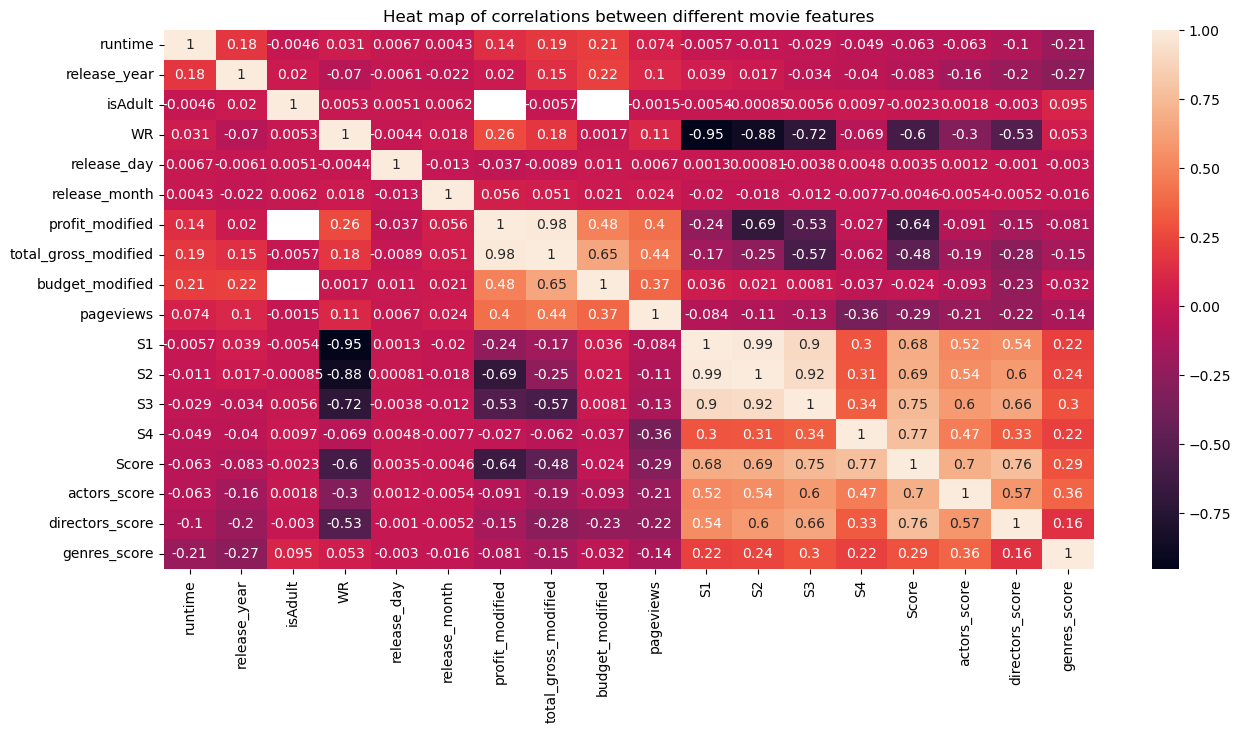

In [591]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all[[
    'runtime', 'release_year', 'isAdult', 'WR', 'release_day', 'release_month', 'profit_modified', 'total_gross_modified',
    'budget_modified', 'pageviews', 'S1', 'S2', 'S3', 'S4', 'Score', 'actors_score', 'directors_score', 'genres_score'
]].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features')

#### One hot encoding for list values

In [592]:
df_all_ohe = df_all.copy()

In [593]:
def one_hot_encoding_list(df, column_name, top_count):
    top = pd.Series([el for _list in df[column_name] for el in _list]).value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda _list: [el if el in top else 'Other' for el in _list])
    result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
    result.fillna({f'{column_name}_{el}': 0 for el in list(top) + ['Other']}, inplace=True)
    result.drop([column_name], axis=1, inplace=True)
    return result

In [594]:
def one_hot_encoding(df, column_name, top_count):
    top = df[column_name].value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda el: el if el in top else 'Other')
    result = df.join(pd.get_dummies(df[column_name], prefix=column_name).groupby(level=0).max())
    result.drop([column_name], axis=1, inplace=True)
    return result

In [595]:
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'genre', 25)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'languages', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'countries', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'directors', 30)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'writers', 30)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_5729/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_5729/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_5729/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[

#### Expand the list values

In [596]:
df_all_expanded = df_all.copy()

In [597]:
df_all_expanded = df_all_expanded.explode('genre')
df_all_expanded = df_all_expanded.explode('languages')
df_all_expanded = df_all_expanded.explode('countries')
df_all_expanded = df_all_expanded.explode('directors')
df_all_expanded = df_all_expanded.explode('writers')

In [598]:
df_all_expanded.sample(5)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name,actors_score,directors_score,genres_score
48131,/m/02jxrw,Frida,120.0,Spanish,Canada,2002.0,0.0,Julie Taymor,Diane Lake,7.299981,...,0.002325,6245,1433,2877,48132,1433,"[Salma Hayek, Alfred Molina, Antonio Banderas,...",14757.180023,3093.000000,20301.297983
58028,/m/02qvr8t,Angel,90.0,Greek,Ireland,1982.0,0.0,Neil Jordan,Neil Jordan,6.303587,...,NaN,22574,23595,27264,58029,22574,"[Stephen Rea, Ian McElhinney, Ray McAnally, Ma...",20342.448990,6291.466667,23874.312262
15862,/m/055zb2,Boys Life 3,78.0,French,United States of America,2000.0,0.0,Gregory Cooke,Bradley Rust Gray,6.309791,...,0.000019,22224,23245,7891,15863,7891,"[Sara Gilbert, Alexis Arquette, Jason Gould, G...",14019.034283,7891.000000,21309.771979
24288,/m/04j088m,Love Comes Lately,86.0,NaN,Germany,2007.0,0.0,Jan Schütte,Jan Schütte,5.619942,...,0.000007,32938,33417,8139,24289,8139,"[Olivia Thirlby, Rhea Perlman, Caroline Aaron,...",12520.580205,20397.500000,21429.803815
47171,/m/0dlns08,Tower Heist,104.0,English,United States of America,2011.0,0.0,Brett Ratner,Jeff Nathanson,6.200026,...,0.013201,25037,762,734,47172,734,"[Desmin Borges, Ben Stiller, Eddie Murphy, Mat...",8272.589581,4525.363636,23701.075277


For the final dataset obtained, we gather data from 4 different sources. In order to not restrain ourselves to only common features and end up with a smaller dataset, we made the choice of outer merges filled with NaN. Indeed, if we had taken inner merge of all datasets, it might be that our final dataset is both small and not badly representative of the population. 

Having NaN values has however some consequences on our data analysis. It might be that the NaN are not fully random, for instance, runtime for Crime movies are all missing values while we have the runtime for all Comedies. This should ideally be investigated further to check the NaN are indeed random. In the framework of this milestone, the choice was to focus on other tasks. We will thus assume randomness of NaN values.



### Save dataframe to avoid running pre-processing

In [599]:
df_all.to_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8')
df_all_expanded.to_csv('./handled_data/dataframes/df_all_expanded.csv',encoding='utf-8')
df_all_ohe.to_csv('./handled_data/dataframes/df_all_ohe.csv',encoding='utf-8')
characters.to_csv('./handled_data/dataframes/characters.csv',encoding='utf-8')

### Read processed dataframe to avoid running pre-processing

In [600]:
# import ast
# df_all = pd.read_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8',index_col=0, na_values='',converters={column :ast.literal_eval for column in ['languages', 'countries', 'directors', 'writers', 'genre']})
# df_all_expanded = pd.read_csv('./handled_data/dataframes/df_all_expanded.csv',encoding='utf-8',index_col=0)
# df_all_ohe = pd.read_csv('./handled_data/dataframes/df_all_ohe.csv',encoding='utf-8',index_col=0)
# characters = pd.read_csv('./handled_data/dataframes/characters.csv',encoding='utf-8',index_col=0)

### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the gross revenue.

In [601]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the release month information for {df_all['release_month'].count()} movies which is a big enough dataset to be representative.")

Out of 82605 movies in out dataset, we have the release month information for 43783 movies which is a big enough dataset to be representative.


In [602]:
df_release = df_all.dropna(how='all', subset=['release_month']) # Remove NaN months

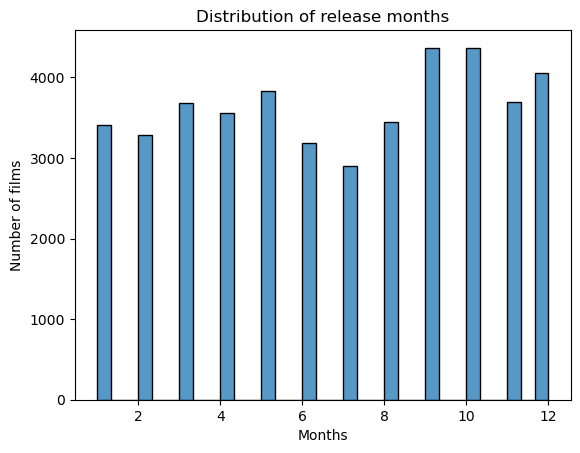

In [603]:
sns.histplot(x='release_month', data = df_release).set(title='Distribution of release months',xlabel='Months', ylabel='Number of films');

From the plot above, we can see that the distribution of release months is fairly homogeneous accross the data which allows to investigate success accross different release months.

In [604]:
df_release=df_release.sort_values(by='release_month', ascending=True)

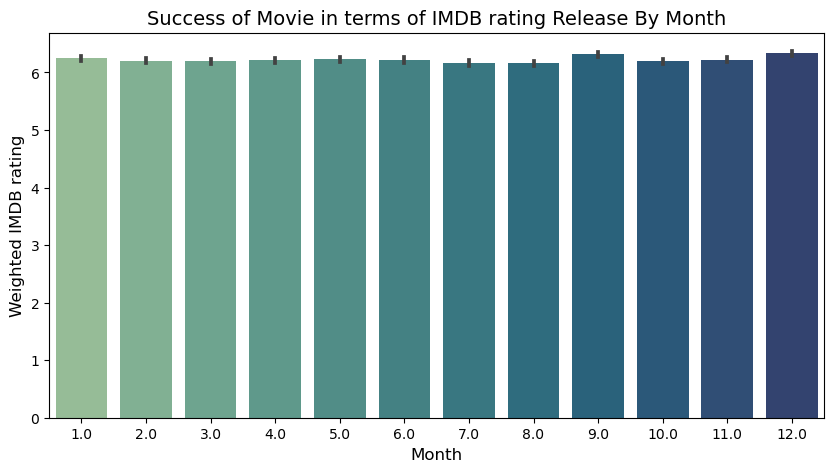

In [605]:
# Plot
plt.figure(figsize=(10,5));
ax = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest');
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Success of Movie in terms of IMDB rating Release By Month', fontsize=14);

Text(0.5, 1.0, 'Success in terms of revenue of Movie Release By Month')

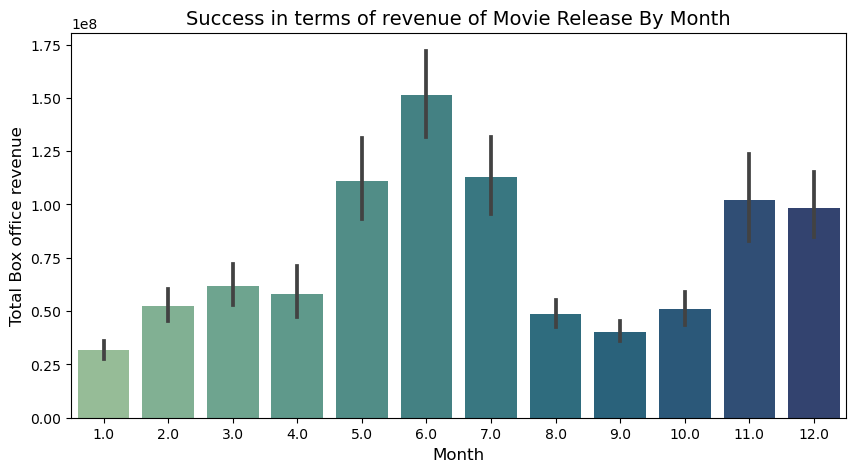

In [606]:
# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x="release_month", y="total_gross_modified",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Box office revenue', fontsize=12)
plt.title('Success in terms of revenue of Movie Release By Month', fontsize=14)

As we can see from the results above, the movie weighted ratings are not at all influenced by the release period. However, the gross revenue is. We see that movies released in summer and in the end of the year are more successful.  Since the distribution of movies is fairly the same across our dataset, we can deduce that these periods are more favourable for movie release. It interesting to note that these results coincide with usual holidays periods where people have more time to go to the cinema. 

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare mainly three features, the budget spent 'Production Budget', the profit made 'profit' and the weighted rating of the movie to account for successfulness 'WR'.


In [607]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the profit information for {df_all['profit_modified'].count()} movies, total gross revenue information for {df_all['total_gross_modified'].count()} movies , budget information for {df_all['budget_modified'].count()} movies.")


Out of 82605 movies in out dataset, we have the profit information for 2464 movies, total gross revenue information for 8392 movies , budget information for 3828 movies.


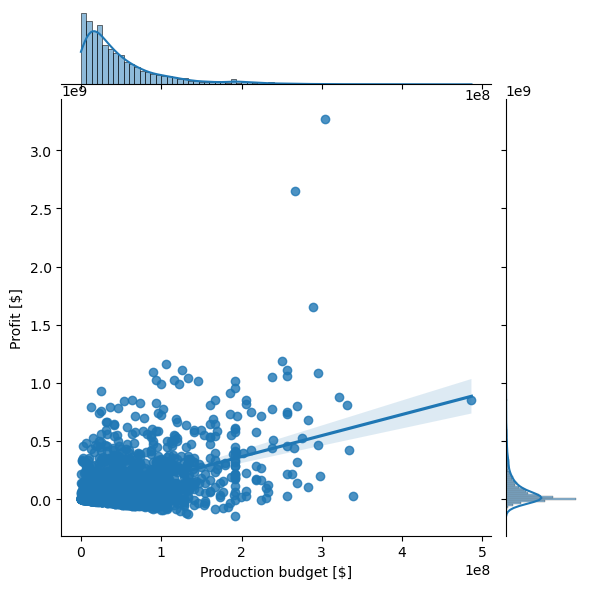

In [608]:
h = sns.jointplot(data=df_all, x='budget_modified', y='profit_modified', kind="reg");
h.ax_joint.set_xlabel('Production budget [$]');
h.ax_joint.set_ylabel('Profit [$]');

As we can see from the plot above, the positive trend line indicates that an increase in the budget will result in an increase in profit. However, there seems to be a lot of outliers. For our datastory (Milestone 3), it would be interesting to split this into two categories, high budget movies and average movies. Additionnaly, we will want to investigate if this budget trend is different across genres.

To compare the link between all three features, we build the pairplot below:

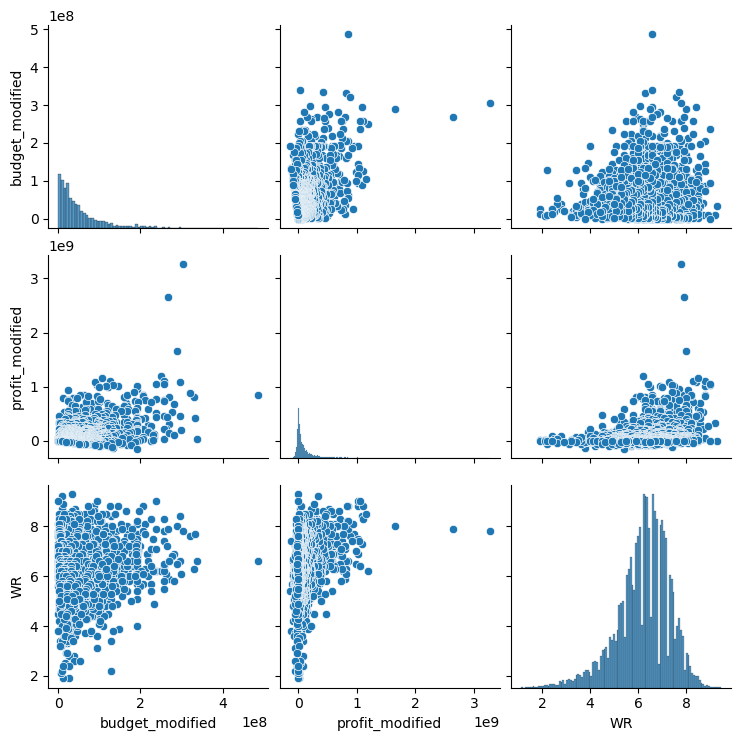

In [609]:
sns.pairplot(df_all[['budget_modified','profit_modified','WR']]);

### Top 20 most profitable movies

In [610]:
Top20_ProfitableMovies = df_all.sort_values('profit_modified', ascending=False).head(20)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_5729/3285713744.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['profit_modified'],
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_5729/3285713744.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['budget_modified'],


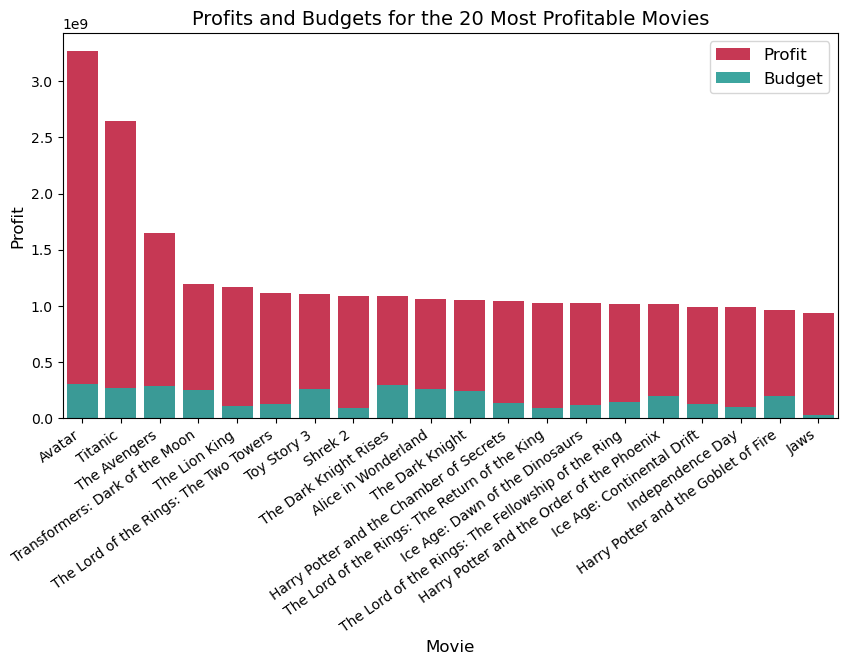

In [611]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

## Impact of director

In [612]:
(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False

0         True
0        False
0        False
0        False
1         True
         ...  
82603    False
82603    False
82604     True
82604    False
82604    False
Length: 916591, dtype: bool

In [613]:
df_all_expanded.head()

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name,actors_score,directors_score,genres_score
0,/m/0crd14y,Madonna,85.0,Croatian,Croatia,1999.0,NaN,NaN,NaN,NaN,...,NaN,44616,44630,46108,1,1,"[Goran Navojec, Lucija Šerbedžija, Ljubomir Ke...",35021.284615,NaN,24642.626291
0,/m/0crd14y,Madonna,85.0,Serbian,Croatia,1999.0,NaN,NaN,NaN,NaN,...,NaN,44616,44630,46108,1,1,"[Goran Navojec, Lucija Šerbedžija, Ljubomir Ke...",35021.284615,NaN,24642.626291
0,/m/0crd14y,Madonna,85.0,Croatian,Croatia,1999.0,NaN,NaN,NaN,NaN,...,NaN,44616,44630,46108,1,1,"[Goran Navojec, Lucija Šerbedžija, Ljubomir Ke...",35021.284615,NaN,24642.626291
0,/m/0crd14y,Madonna,85.0,Serbian,Croatia,1999.0,NaN,NaN,NaN,NaN,...,NaN,44616,44630,46108,1,1,"[Goran Navojec, Lucija Šerbedžija, Ljubomir Ke...",35021.284615,NaN,24642.626291
1,/m/07cz2,The Matrix,135.0,English,United States of America,1999.0,0.0,Lana Wachowski,Lilly Wachowski,8.699995,...,0.04163,95,91,121,2,2,"[Belinda McClory, Keanu Reeves, Laurence Fishb...",13801.123963,952.833333,19254.627776


In [614]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the director information for {df_all_expanded[(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False]['directors'].count()} movies coming from the IMDB data set.")

Out of 82605 movies in out dataset, we have the director information for 43724 movies coming from the IMDB data set.


In [615]:
df_director = df_all_expanded.dropna(how='all', subset=['directors']).drop_duplicates(['name', 'release_year', 'directors']) # Remove NaN directors

In [616]:
Top20_ProfitableMovies = df_director.sort_values('profit_modified', ascending=False).head(20)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_5729/708278559.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['profit_modified'],
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_5729/708278559.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['budget_modified'],


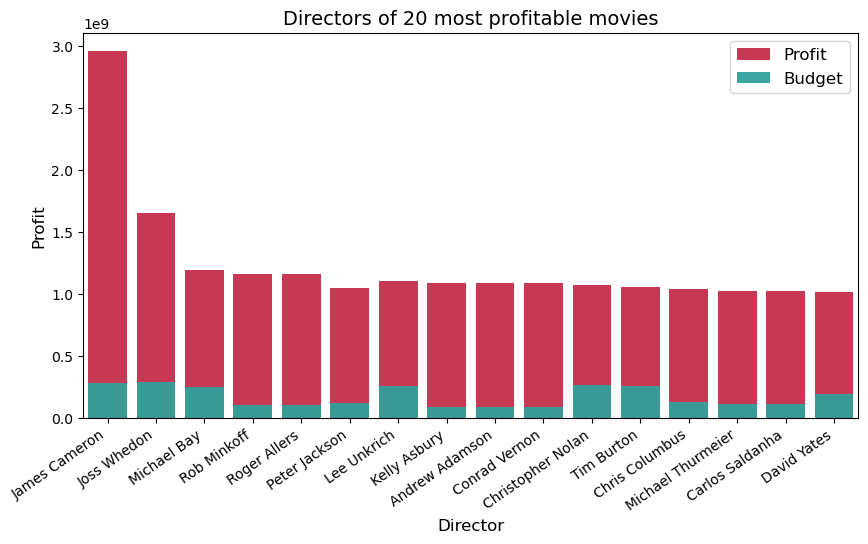

In [617]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [618]:
Top20_ProfitableMovies['directors']

46823        James Cameron
46824        James Cameron
14177          Joss Whedon
395            Michael Bay
46826          Rob Minkoff
46826         Roger Allers
296          Peter Jackson
484            Lee Unkrich
440           Kelly Asbury
440         Andrew Adamson
440          Conrad Vernon
34       Christopher Nolan
7174            Tim Burton
46825    Christopher Nolan
1121        Chris Columbus
162          Peter Jackson
1345     Michael Thurmeier
1345       Carlos Saldanha
96           Peter Jackson
1019           David Yates
Name: directors, dtype: object

## Impact of actors

In order to assess the added value of actors to a movie's success, it is necessary to define the success of individual actors. To do this, we first create an actors dataset. We also compute in how many films in the dataset the actor appears, this value can be found in the column `num_movies`.

In [619]:
characters
pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name_x,actor_age_at_movie_release,...,total_gross_modified_norm,S1,S2,S3,S4,Score,actor_name_y,actors_score,directors_score,genres_score
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",13743.604759,6192.125,22054.803681
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",13743.604759,6192.125,22054.803681
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",13743.604759,6192.125,22054.803681
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",13743.604759,6192.125,22054.803681
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,0.001258,39158.0,39322.0,3824.0,1786.0,1786.0,"[Wanda De Jesus, Natasha Henstridge, Ice Cube,...",13743.604759,6192.125,22054.803681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453620,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,...,NaN,81554.0,81554.0,81554.0,38619.0,38619.0,"[Isshin Chiba, Tsutomu Takayama, 笠原弘子, Yumi Tō...",34973.954709,NaN,27407.576551
453621,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,...,NaN,81554.0,81554.0,81554.0,38619.0,38619.0,"[Isshin Chiba, Tsutomu Takayama, 笠原弘子, Yumi Tō...",34973.954709,NaN,27407.576551
453622,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,...,NaN,4835.0,6910.0,12459.0,31064.0,4835.0,"[David Hemmings, Roberta Paterson, John Rogers]",11311.626984,4835.000,23627.176258
453623,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,...,NaN,4835.0,6910.0,12459.0,31064.0,4835.0,"[David Hemmings, Roberta Paterson, John Rogers]",11311.626984,4835.000,23627.176258


In [620]:
characters.columns

Index(['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date',
       'character_name', 'actor_birthdate', 'actor_gender',
       'actor_height_meters', 'actor_ethnicity_freebase_id', 'actor_name',
       'actor_age_at_movie_release', 'freebase_character_actor_map_id',
       'freebase_character_id', 'freebase_actor_id', 'name', 'ethnicity_label',
       'major_ethnicity', 'num_movies'],
      dtype='object')

In [621]:
actors = pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')
actors.columns

Index(['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date',
       'character_name', 'actor_birthdate', 'actor_gender',
       'actor_height_meters', 'actor_ethnicity_freebase_id', 'actor_name_x',
       'actor_age_at_movie_release', 'freebase_character_actor_map_id',
       'freebase_character_id', 'freebase_actor_id', 'name_x',
       'ethnicity_label', 'major_ethnicity', 'num_movies', 'freebase_id',
       'name_y', 'runtime', 'languages', 'countries', 'release_year',
       'isAdult', 'directors', 'writers', 'WR', 'genre', 'release_day',
       'release_month', 'profit_modified', 'total_gross_modified',
       'budget_modified', 'pageviews', 'total_gross_modified_std',
       'total_gross_modified_norm', 'S1', 'S2', 'S3', 'S4', 'Score',
       'actor_name_y', 'actors_score', 'directors_score', 'genres_score'],
      dtype='object')

In [622]:
actors = pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')
actors = actors[['freebase_actor_id', 'freebase_movie_id', 'actor_name', 'actor_gender', 'actor_height_meters', 'ethnicity_label', 'major_ethnicity', 'WR']]
actors = actors.dropna(subset=['freebase_actor_id'])
#actors['mean_WR'] = actors.groupby(by=['freebase_actor_id']).mean(numeric_only=True)['WR']

actors['num_movies'] = actors.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')
actors['WR_mean'] = actors[['freebase_actor_id', 'WR']].groupby(by=['freebase_actor_id']).transform('mean')
actors.drop(['freebase_movie_id'], axis=1, inplace=True)
actors.drop_duplicates(subset=['freebase_actor_id'], inplace=True)


KeyError: "['actor_name'] not in index"

In [ ]:
characters.groupby('actor_name').count()

In [ ]:
#Apply weighting to score
WR_actors_mean = np.mean(actors.WR_mean)
min_movies = 1

def isNan(value):
    return value!=value

def get_weigthed_WR(WR, num_movies):
    if not isNan(WR) and not isNan(num_movies):
        if num_movies > min_movies:
            return num_movies/(num_movies + min_movies) * WR + min_movies/(num_movies + min_movies) * WR_actors_mean
    return np.nan

actors['WR'] = actors.apply(lambda row: get_weigthed_WR(row['WR_mean'], row['num_movies']), axis=1)



In [ ]:
actors.head()

In [ ]:
top_20_actors = actors.dropna(subset=['WR']).sort_values(by='WR', ascending=False).iloc[0:20]

top_20_actors.head()

In [ ]:
plt.figure(figsize=(10,5));
sns.barplot(x=top_20_actors['actor_name'],y=top_20_actors['WR'], 
            color='crimson', alpha=0.95, ci=None);
plt.xlabel('Actors', fontsize=12);
plt.title("Top 20 successful actors", fontsize=14);
plt.ylabel('Success score', fontsize=12);
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10);

### TO UPDATE ANYTHING BELOW

In [ ]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the 1st actor information for {df_all['Star1'].count()} movies coming from the top 1000 IMDB data set.")

For now, we only consider the main actor of a movie but this can be extrapolated to all actors accross multiple movies for our next milestone. 

In [ ]:
df_main_actor = df_all.dropna(how='all', subset=['Star1']) # Remove NaN actors

In [ ]:
Top20_ProfitableMovies = df_main_actor.sort_values('profit_modified', ascending=False).head(20)

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Actors', fontsize=12)
plt.title("Actors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

For our datastory, the goal would be to cluster actors accross genres. That way, we can forecast which actor would be best to select for a particular genre to boost success.

## Popular features in characters

The characters table is splitted between actors and actresses to study each gender as a whole different group.

In [ ]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

The following plot presents the height distribution for the actors and actresses. We can see that men tend to be taller than women actors. Also, it can be seen that in the dataset there are way more men than women

In [ ]:
def filter_children(characters):
    LIMIT_CHILDREN_AGE = 14
    return characters[(characters['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]

def characters_height_histogram(characters, bins):
    characters_height = characters.dropna(subset=['actor_height_meters'])
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(filter_children(characters_male), bins=40)
characters_height_histogram(filter_children(characters_female), bins=25)


Another important characteristic we can study is the age on movie release. Again, there is a huge difference between women and men. Women play roles when they are younger, while men seem to have longer careers.

In [ ]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

The following plot shows the ethnicity distribution for actors and actresses of the dataset. It can be seen how white people clearly dominate the characters dataset by more than a half of it. Indians are also a big group representing 1/4 of the ethnicities. In this case, the difference between genders is not that big.

In [ ]:
def pie_chart_actor_ethnicities(actors, title, ax):
    actors_ethnicity = actors.dropna(subset=['major_ethnicity'])
    actors_ethnicity = actors_ethnicity[actors_ethnicity['major_ethnicity'] != 'unknown']
    ethnicities, counts = np.unique(actors_ethnicity['major_ethnicity'], return_counts=True)
    #print(np.sort(counts))
    others_count = 0
    plot_ethnicities = []
    plot_counts = []
    ETHNICITY_THRESHOLD = 1
    for ethnicity, count in zip(ethnicities, counts):
        if count > ETHNICITY_THRESHOLD:
            plot_ethnicities.append(ethnicity)
            plot_counts.append(count)
        else:
            others_count += count

    colors = ['#e8bd9b','#402b28','#996044','#dba577','#f0dfd7']

    ax.pie(plot_counts, labels=plot_ethnicities, startangle=90,autopct='%1.1f%%',colors=colors, radius=1)
    ax.set_title(title)

def two_pie_charts_actor_ethnicities(actors1, actors2, title, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_facecolor('white')
    fig.set_size_inches(11, 5)
    fig.suptitle(title)

    pie_chart_actor_ethnicities(actors1, title1, ax1)
    pie_chart_actor_ethnicities(actors2, title2, ax2)
    plt.show()


two_pie_charts_actor_ethnicities(characters_male, 
                                 characters_female, 
                                 title='Ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

The next plot shows the number of different ethnicities per movie. For instance, a movie that includes at least one Indian and one Black actress has 2 different ethnicities. As we can see, the vast majority of the films only have one ethnicity on it.

In [ ]:
def plot_different_ethnicities_per_movie(characters):
    ethnicity_characters = characters.dropna(subset=['major_ethnicity'])
    num_different_ethnicities = ethnicity_characters.groupby(by=['freebase_movie_id'])['major_ethnicity'].nunique()
    num_ethnicies, count = np.unique(num_different_ethnicities, return_counts=True)
    plt.bar(num_ethnicies, count)
    plt.xlabel('Number of different major ethnicities')
    plt.ylabel('Number of movies')
    plt.title('Distribution of different ethnicities per movie')
plot_different_ethnicities_per_movie(characters)

Again, let's split actors in genders

In [ ]:
actors_male = actors[actors['actor_gender'] == 'M']
actors_female = actors[actors['actor_gender'] == 'F']

And now we can focus on the actors that have appeared in a greater number of movies. We fix this threshold at 15 movies.

In [ ]:
def get_most_demanded_actors(actors, min_num_movies):
    return actors[actors['num_movies'] >= min_num_movies]

MIN_NUM_MOVIES_DEMANDED_ACTOR = 5
demanded_actors_male = get_most_demanded_actors(actors_male, MIN_NUM_MOVIES_DEMANDED_ACTOR)
demanded_actors_female = get_most_demanded_actors(actors_female, MIN_NUM_MOVIES_DEMANDED_ACTOR)


This way, we can compare if the most characteristic features of each actor are the same for the whole dataset of characters. We are plotting again the height distribution both for males and females.

In [ ]:
characters_height_histogram(demanded_actors_male, 40)
characters_height_histogram(demanded_actors_female, 15)

Also, the ethnicities are plotted again. We can observe that discriminations are even bigger.

In [ ]:
two_pie_charts_actor_ethnicities(demanded_actors_male, 
                                demanded_actors_female, 
                                 title='Top actors ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

All these data about characters is going to be merged and analysed for the last milestone. By now, we have demonstrated that we have data enough to work and answer the proper questions

Get score for actors and actresses

In [ ]:
df_test = df_all.dropna(subset=['WR'])
df_test.sort_values(by='WR', ascending=False)

# def isNaN(string):
#     return string!=string

# def get_movie_feature_by_id(freebase_movie_id, feature):
#     if not isNaN(freebase_movie_id):
#         #print(freebase_movie_id)
#         a = df_test.loc[df_all['freebase_id'] == freebase_movie_id]
#         if (len(a) > 0):
#             print(a[feature])
#             return a[feature][0].item()
#     return np.nan


# # characters['movie_score'] = characters.apply(lambda row : get_movie_feature_by_id(row['freebase_movie_id'], 'WR'), axis=1)

# # characters.dropna(subset='movie_score')

# # characters.iloc[0]['freebase_movie_id']

# characters.apply(lambda row : get_movie_feature_by_id(row['freebase_movie_id'], 'WR'), axis=1)


## What genres are the most profitable?

In [ ]:
df_all['profit_modified'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution');

In [ ]:
df_genre = df_all_expanded.dropna(how='all', subset=['genre']).drop_duplicates(['name', 'release_year', 'genre'])

In [ ]:
genres = df_genre['genre'].value_counts()

In [ ]:
genres[genres > 1000].plot(kind='bar', title='Movie genres distribution');

In [ ]:
plt.figure(figsize=(15,5));
ax = sns.barplot(
    x="genre",
    y="profit_modified",
    data=df_genre[df_genre['profit_modified'].notna() & df_genre['genre'].isin(genres[genres > 1000].index.to_list())],
    palette='crest'
)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.title('Success of Movie based on genre in terms of the profit', fontsize=14)
_ = plt.xticks(rotation=90)

## Correlation between the choice of topics and movie profitability can be investigated

In [ ]:
df_genre['genre_category'] = df_genre['genre'].astype('category').cat.codes

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_genre.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

## Clustering between movies: Classics VS forgettable : check with wikipedia ID how much it is visited : time series of access 

In [ ]:
df_all_ohe.sample(5)

In [ ]:
df_all_ohe_cleaned_columns = df_all_ohe.rename({c: c.replace('/', '').replace('.', '').replace(' ', '').replace('\'', '').replace('-', '') for c in df_all_ohe.columns}, axis=1)

In [ ]:
mod = smf.ols(formula=
    'pageviews ~ runtime + release_year + WR + release_month + profit_modified + genre_Action + ' +
    'genre_ActionAdventure + genre_Adventure + genre_Animation + genre_Blackandwhite + genre_Comedy + ' +
    'genre_Comedyfilm + genre_CrimeFiction + genre_Documentary + genre_Drama + genre_FamilyFilm + ' + 
    'genre_Fantasy + genre_Horror + genre_Indie + genre_Musical + genre_Mystery + genre_Other + ' + 
    'genre_RomanceFilm + genre_Romanticcomedy + genre_Romanticdrama + genre_ScienceFiction + genre_ShortFilm + ' + 
    'genre_Silentfilm + genre_Thriller + genre_Warfilm + genre_Worldcinema + languages_Cantonese + ' + 
    'languages_English + languages_French + languages_German + languages_Hindi + languages_Italian + ' + 
    'languages_Japanese + languages_Korean + languages_Malayalam + languages_Other + languages_Russian + ' + 
    'languages_Silentfilm + languages_Spanish + languages_StandardMandarin + languages_Tamil + languages_Telugu + ' + 
    'countries_Argentina + countries_Australia + countries_Canada + countries_France + countries_Germany + ' + 
    'countries_HongKong + countries_India + countries_Italy + countries_Japan + countries_Mexico + ' + 
    'countries_Netherlands + countries_Other + countries_SouthKorea + countries_Spain + countries_UnitedKingdom + ' + 
    'countries_UnitedStatesofAmerica + directors_AlfredHitchcock + directors_CecilBDeMille + ' + 
    'directors_CharlesChaplin + directors_CharlesLamont + directors_ChuckJones + directors_DWGriffith + ' + 
    'directors_DaveFleischer + directors_FrizFreleng + directors_GeorgeCukor + directors_GeorgeMarshall + ' + 
    'directors_GordonDouglas + directors_HenryHathaway + directors_JohnFord + directors_JosephBarbera + ' + 
    'directors_JosephKane + directors_JulesWhite + directors_MichaelCurtiz + directors_NormanTaurog + ' + 
    'directors_Other + directors_RaoulWalsh + directors_RayTaylor + directors_RichardThorpe + directors_RobertFMcGowan + ' + 
    'directors_RobertFlorey + directors_RobertMcKimson + directors_RoscoeFattyArbuckle + directors_SamNewfield + ' + 
    'directors_WilliamAWellman + directors_WilliamBeaudine + directors_WilliamHanna + directors_WilliamWitney + ' + 
    'writers_ArthurConanDoyle + writers_BasilDickey + writers_BenHecht + writers_CareyWilson + writers_CharlesChaplin + ' + 
    'writers_CharlesDickens + writers_DWGriffith + writers_DudleyNichols + writers_EdgarRiceBurroughs + writers_ElwoodUllman + ' + 
    'writers_FelixAdler + writers_FrancesMarion + writers_GeorgeHPlympton + writers_GopalakrishnaParuchuri + writers_HMWalker + ' + 
    'writers_HalRoach + writers_JohnWDunn + writers_KaderKhan + writers_MichaelMaltese + writers_NunnallyJohnson + writers_Other + ' + 
    'writers_ParuchuriVenkateswaraRao + writers_RahiMasoomReza + writers_RobertAMcGowan + writers_SachinBhowmick + writers_Satyanand + ' + 
    'writers_StephenKing + writers_TeddPierce + writers_ValGuest + writers_WarrenFoster + writers_WilliamShakespeare',
  data=df_all_ohe_cleaned_columns)
np.random.seed(2)
res = mod.fit()
res.summary()

## Countries

In [ ]:
# sort by country
import json
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
data = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
# movies=movies['countries'].apply(lambda row: len((eval(row).values())))
movies=movies['countries'].apply(lambda row: (eval(row).values()))
movies= pd.DataFrame(movies,columns=['countries'])
# movies['countries'].apply(len)
# movies.describe()
movies.head()


In [ ]:


# movies=movies['countries'].apply(lambda row: (eval(row).values()))
# movies= pd.DataFrame(movies,columns=['countries'])
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('test.csv')
# US=movies['countries'].apply(lambda lis : "United States of America" in lis and len(lis)==1)
US=movies['countries'].apply(lambda lis : "United States of America" in lis)
US_movies=data.loc[US]
print('number of movies made in the US: ',US.sum())
IN=movies['countries'].apply(lambda lis : "India" in lis)
IN_movies=movies[IN]
print('number of movies made in india: ',IN.sum())

mult=movies['countries'].apply(lambda lis : len(lis)>1)
print('number of movies made in more than one country: ',sum(mult))


In [ ]:

# one list with all the countries of all the movies
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('handled_data/test.csv')


In [ ]:



from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count.head(20).index.to_series(),count.head(20))
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count[1:51].index.to_series(),count[1:51])
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);


In [ ]:


# sort movies by date 
data[(data['release_date']<'2000') & (data['release_date']>='1995')]
set1=data[data['release_date']<'1985']
set2=data[data['release_date']>'1985']
set1=set1['countries']
set2=set2['countries']
def analysis(set) :
    set=set.apply(lambda row: (eval(row).values()))
    set= pd.DataFrame(set,columns=['countries'])
    exploded=pd.DataFrame([[c] for C in set['countries'] for c in C],columns=['countries'])
    # len(exploded['countries'].unique())
    count=exploded['countries'].value_counts()
    count.to_csv('test.csv')
    return count

c1=analysis(set1)
c2=analysis(set2)


In [ ]:
fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c1.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies before 1985')
plt.show()
# plot_countries


In [ ]:

fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c2.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies after 1985')
plt.show()

# Train NN for predicting revenue

In [696]:
df_all_ohe.columns

Index(['freebase_id', 'name', 'runtime', 'release_year', 'isAdult', 'WR',
       'release_day', 'release_month', 'profit_modified',
       'total_gross_modified',
       ...
       'writers_Paruchuri Venkateswara Rao', 'writers_Rahi Masoom Reza',
       'writers_Robert A. McGowan', 'writers_Sachin Bhowmick',
       'writers_Satyanand', 'writers_Sonya Levien', 'writers_Stephen King',
       'writers_Tedd Pierce', 'writers_Warren Foster',
       'writers_William Shakespeare'],
      dtype='object', length=143)

In [697]:
df_all.describe()

,runtime,release_year,isAdult,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,actors_score,directors_score,genres_score
count,68104.000000,75770.000000,44031.000000,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,46823.000000,8.392000e+03,8.392000e+03,82605.00000,82605.00000,82605.00000,82605.00000,82605.000000,64122.000000,43725.000000,80848.000000
mean,93.965487,1977.970581,0.002566,6.224498,15.658129,6.707717,9.605612e+07,6.483874e+07,5.092346e+07,2734.818491,1.354705e-17,4.363016e-03,41303.00000,41303.00000,41303.00000,41303.00000,28494.129435,23311.439993,15341.646476,24969.472895
std,59.949382,29.228580,0.050595,1.102334,8.708539,3.483054,1.897343e+08,1.487117e+08,5.505716e+07,11517.211493,1.000000e+00,1.000685e-02,23846.15383,23846.15383,23846.15383,23846.15383,22434.175436,11320.952351,8998.272912,3934.159816
min,0.000000,1010.000000,0.000000,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000,-4.359263e-01,7.660325e-07,1.00000,1.00000,1.00000,1.00000,1.000000,40.000000,2.000000,2682.333333
25%,80.000000,1956.000000,0.000000,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,47.083004,-4.171539e-01,1.886180e-04,20652.00000,20652.00000,20652.00000,20652.00000,8758.000000,15309.253042,8601.000000,22503.138129
50%,93.000000,1986.000000,0.000000,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,238.284585,-3.380567e-01,9.801326e-04,41303.00000,41303.00000,41303.00000,41303.00000,23903.000000,21076.555556,14354.327586,24487.561164
75%,108.000000,2004.000000,0.000000,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1094.704134,-4.740050e-02,3.888687e-03,61954.00000,61954.00000,61954.00000,61954.00000,42900.000000,28804.169297,20606.666667,27035.947621
max,5700.000000,2020.000000,1.000000,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,410868.409091,2.356975e+01,2.402221e-01,82605.00000,82605.00000,82605.00000,82605.00000,82604.000000,81529.000000,44001.000000,45125.142857


In [698]:
df_all_ohe.describe()

,runtime,release_year,isAdult,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews,...,writers_Paruchuri Venkateswara Rao,writers_Rahi Masoom Reza,writers_Robert A. McGowan,writers_Sachin Bhowmick,writers_Satyanand,writers_Sonya Levien,writers_Stephen King,writers_Tedd Pierce,writers_Warren Foster,writers_William Shakespeare
count,68104.000000,75770.000000,44031.000000,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,46823.000000,...,82605.000000,82605.000000,82605.000000,82605.000000,82605.000000,82605.000000,82605.00000,82605.000000,82605.000000,82605.000000
mean,93.965487,1977.970581,0.002566,6.224498,15.658129,6.707717,9.605612e+07,6.483874e+07,5.092346e+07,2734.818491,...,0.000811,0.000678,0.000799,0.000884,0.000605,0.000593,0.00069,0.001259,0.001259,0.001198
std,59.949382,29.228580,0.050595,1.102334,8.708539,3.483054,1.897343e+08,1.487117e+08,5.505716e+07,11517.211493,...,0.028468,0.026028,0.028255,0.029715,0.024595,0.024348,0.02626,0.035460,0.035460,0.034598
min,0.000000,1010.000000,0.000000,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,80.000000,1956.000000,0.000000,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,47.083004,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,93.000000,1986.000000,0.000000,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,238.284585,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,108.000000,2004.000000,0.000000,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1094.704134,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,5700.000000,2020.000000,1.000000,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,410868.409091,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [626]:
dataset = df_all_ohe.copy()
dataset.set_index('freebase_id', inplace=True)
df_all.set_index('freebase_id', inplace=True)
dataset[['Score', 'actors_score', 'directors_score']] = df_all[['Score', 'actors_score', 'directors_score']]
dataset.reset_index(inplace=True)
df_all.reset_index(inplace=True)

In [746]:
dataset = df_all_ohe.copy()

In [747]:
dataset = dataset[dataset['Score'].notna()]

In [748]:
dataset.drop([
    c for c in dataset.columns
    if c in ['freebase_id', 'name', 'release_year', 'WR', 'genres_score', 'actor_name', 'release_day', 'profit_modified', 'total_gross_modified', 'total_gross_modified_std', 'pageviews', 'total_gross_modified_norm', 'genre_Other', 'languages_Other', 'countries_Other', 'budget_modified', 'S1', 'S2', 'S3', 'S4'] or 
    (c.startswith('directors_') and c != 'directors_score') or c.startswith('writers_') or c.startswith('genre_') or c.startswith('countries_') or c.startswith('languages_')], axis=1, inplace=True)

In [749]:
dataset.head()

,runtime,isAdult,release_month,Score,actors_score,directors_score
0,85.0,NaN,NaN,1,35021.284615,NaN
1,135.0,0.0,3.0,2,13801.123963,952.833333
2,181.0,NaN,4.0,3,NaN,NaN
3,133.0,NaN,7.0,4,NaN,NaN
4,89.0,0.0,NaN,5,17558.952048,10856.857143


In [730]:
dataset.describe()

,runtime,isAdult,release_month,Score,actors_score,directors_score
count,68104.000000,44031.000000,43783.000000,82605.000000,64122.000000,43725.000000
mean,93.965487,0.002566,6.707717,28494.129435,23311.439993,15341.646476
std,59.949382,0.050595,3.483054,22434.175436,11320.952351,8998.272912
min,0.000000,0.000000,1.000000,1.000000,40.000000,2.000000
25%,80.000000,0.000000,4.000000,8758.000000,15309.253042,8601.000000
50%,93.000000,0.000000,7.000000,23903.000000,21076.555556,14354.327586
75%,108.000000,0.000000,10.000000,42900.000000,28804.169297,20606.666667
max,5700.000000,1.000000,12.000000,82604.000000,81529.000000,44001.000000


In [731]:
dataset.shape

(82605, 6)

In [732]:
list(dataset.columns)

['runtime',
 'isAdult',
 'release_month',
 'Score',
 'actors_score',
 'directors_score']

In [733]:
dataset = dataset.astype('float32')

In [734]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [735]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
runtime,54546.0,93.788414,54.104946,0.0,80.000000,93.000000,108.000000,5220.0
isAdult,35327.0,0.002717,0.052061,0.0,0.000000,0.000000,0.000000,1.0
release_month,35050.0,6.708017,3.489301,1.0,4.000000,7.000000,10.000000,12.0
Score,66084.0,28431.234375,22405.794922,1.0,8704.750000,23857.500000,42822.250000,82604.0
actors_score,51333.0,23282.552734,11314.516602,40.0,15291.525391,21066.427734,28750.617188,81529.0
directors_score,35076.0,15340.264648,9012.031250,7.0,8615.750000,14342.974609,20565.851562,44001.0


In [736]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Score')
test_labels = test_features.pop('Score')

In [737]:
train_features.shape

(66084, 5)

In [739]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Normalization
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizer_v2.adam import Adam

# from tensorflow.keras.metrics import Recall, Precision
# from tensorflow_addons.metrics import F1Score

total_gross_modified ~ runtime + release_year + isAdult + WR + release_month + budget_modified + pageviews + genre + languages + countries + directors + writers

In [740]:
model = Sequential()
# model.add(Normalization(axis=-1))
model.add(Dense(15, activation="relu"))
model.add(Dense(5, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1))

In [743]:
model.compile(optimizer=Adam(0.001), loss='mean_absolute_error', metrics=['accuracy'])

In [744]:
model.build((0, 5))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (0, 15)                   90        
_________________________________________________________________
dense_23 (Dense)             (0, 5)                    80        
_________________________________________________________________
dense_24 (Dense)             (0, 15)                   90        
_________________________________________________________________
dense_25 (Dense)             (0, 1)                    16        
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________


In [745]:
history = model.fit(train_features, train_labels, batch_size=32, epochs=10, validation_split=0.2)

/Users/nstanishev/opt/anaconda3/envs/epfl-ada/lib/python3.9/site-packages/tensorflow/python/keras/engine/data_adapter.py:1516: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/10


2022-12-19 18:03:17.616154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1653/1653 [==============================] - ETA: 0s - loss: 28522.2090 - accuracy: 5.6746e-05

2022-12-19 18:03:45.734013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1653/1653 [==============================] - 32s 19ms/step - loss: 28522.2090 - accuracy: 5.6746e-05 - val_loss: 28029.4102 - val_accuracy: 0.0000e+00
Epoch 2/10
 186/1653 [==>...........................] - ETA: 27s - loss: 28507.7480 - accuracy: 3.3602e-04

KeyboardInterrupt: 

# Project Milestone 3: data story

## Study data for separate genre

In [ ]:
# Create list of top 15 genre: 
print(genres[genres>1000][0:15])
top_genre = genres[genres>1000][0:15].index.tolist()

Drama              34725
Comedy             16779
Romance Film       10208
Action              9172
Black-and-white     9086
Thriller            8920
Short Film          8125
World cinema        7143
Crime Fiction       6933
Indie               6888
Documentary         5634
Horror              5422
Silent film         5237
Adventure           5228
Family Film         4590
Name: genre, dtype: int64


## Top movies for three success features

We sort df_all by most successful movies according to our three success features. Note that we keep here duplicates for future use.

In [ ]:
# Success in terms of profit: 
df_all_top_profit = df_all_expanded.sort_values('profit_modified', ascending=False)
df_all_top_profit.head(3)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,genre,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
23686,/m/0bth54,Avatar,178.0,English,United Kingdom,2009.0,0.0,James Cameron,James Cameron,7.799997,Thriller,10.0,12.0,3.265843e+09,3.569937e+09,304094700.0,39101.842474
23686,/m/0bth54,Avatar,178.0,English,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,Epic,10.0,12.0,3.265843e+09,3.569937e+09,304094700.0,39101.842474
23686,/m/0bth54,Avatar,178.0,English,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,Thriller,10.0,12.0,3.265843e+09,3.569937e+09,304094700.0,39101.842474


In [ ]:
# Success in terms of weighted IMDB rating: 
df_all_top_WR = df_all_expanded.sort_values('WR', ascending=False)
df_all_top_WR.head(3)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,genre,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
22040,/m/0h5ndj,The Ambassador,27.0,English,United States of America,2008.0,0.0,Rob Sitch,Santo Cilauro,9.467126,Comedy,NaN,NaN,NaN,NaN,NaN,19.194664
22040,/m/0h5ndj,The Ambassador,27.0,English,United States of America,2008.0,0.0,Rob Sitch,Tom Gleisner,9.467126,Comedy,NaN,NaN,NaN,NaN,NaN,19.194664
22040,/m/0h5ndj,The Ambassador,27.0,English,United States of America,2008.0,0.0,Rob Sitch,Rob Sitch,9.467126,Comedy,NaN,NaN,NaN,NaN,NaN,19.194664


## Impact of director

In [ ]:
# Most succesful directors in terms of profit
top_20_directors = df_all_top_profit[df_all_top_profit['genre']=='Drama'].dropna(how='all', subset=['directors']).drop_duplicates(['name', 'release_year', 'directors'])[0:20] # Remove NaN directors

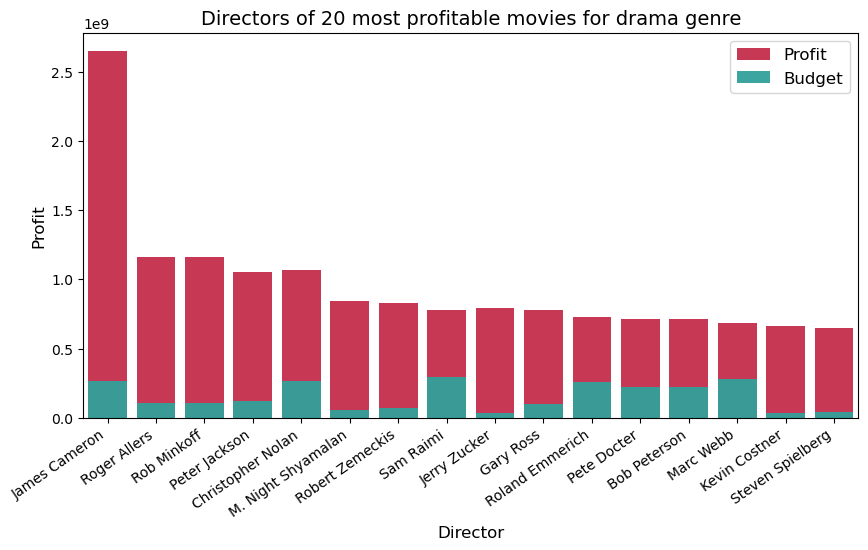

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_20_directors['directors'],y=top_20_directors['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=top_20_directors['directors'],y=top_20_directors['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies for drama genre", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [ ]:
print('pandas',pd.__version__,'networkX', nx.__version__,'pyvis', pyvis.__version__)

pandas 1.3.4 networkX 2.8.4 pyvis 0.3.1


Network graph:
Node size: feature score
Edge width: collaboration score

In [ ]:
N = 15 # number of nodes 
top_N_directors = directors_score.sort_values(by='Score')[0:N]

In [ ]:
ls_top_directors = top_N_directors['directors'].tolist()
director_pairs_score = director_pairs_score.rename({'directors': 'director_pair', 'Score':'Score_pair'}, axis = 1)

# Create a merged dataframe where we have only collaborations which include top directors
df = top_N_directors.merge(director_pairs_score.rename({'directors': 'director_pair', 'Score':'Score_pair'}, axis = 1),how='left',left_on='directors',right_on='directors0')
top_N_directors_graph = df[df['directors1'].isin(df['directors'])]
#del df

# Contains only top directors collaboration
print('Length of dataframe is: ',len(top_N_directors_graph))
top_N_directors_graph.head()


Length of dataframe is:  15


,directors,Score,director_pair,num_movies,Score_pair,directors0,directors1
13,Callie Crossley,15.0,"(Callie Crossley, Terry Kay Rockefeller)",1.0,15.0,Callie Crossley,Terry Kay Rockefeller
14,Thomas Ott,15.0,"(Thomas Ott, Callie Crossley)",1.0,15.0,Thomas Ott,Callie Crossley
15,Thomas Ott,15.0,"(Thomas Ott, Henry Hampton)",1.0,15.0,Thomas Ott,Henry Hampton
19,Thomas Ott,15.0,"(Thomas Ott, Sam Pollard)",1.0,15.0,Thomas Ott,Sam Pollard
20,Thomas Ott,15.0,"(Thomas Ott, Terry Kay Rockefeller)",1.0,15.0,Thomas Ott,Terry Kay Rockefeller


In [ ]:
# Complete with top directors without collaboration
top_N_directors_graph = top_N_directors.merge(top_N_directors_graph,how='left',on=['directors','Score'])
top_N_directors_graph.sample(5)

,directors,Score,director_pair,num_movies,Score_pair,directors0,directors1
2,Tony To,5.0,NaN,NaN,NaN,NaN,NaN
6,Michael Gershman,10.0,NaN,NaN,NaN,NaN,NaN
16,Henry Hampton,15.0,"(Henry Hampton, Callie Crossley)",1.0,15.0,Henry Hampton,Callie Crossley
0,Joe Pinkerton,2.0,NaN,NaN,NaN,NaN,NaN
3,Moirangthem Maniram,7.0,NaN,NaN,NaN,NaN,NaN


## Static Version

In [ ]:
#graph esthetic parameters
max_node_size = 1000
max_edge_width = 100

# normalize scores and define their width in the graph
nodes_scores = top_N_directors_graph.drop_duplicates(subset='directors')['Score']
nodes_size = np.array(nodes_scores)
nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
nodes_size *= max_node_size

#Rescale edge weights: 
weights = top_N_directors_graph['Score_pair'].dropna()
weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
#weights *= max_edge_width
top_N_directors_graph['weight_edge'] = weights

# Create edge data:
edge_data = pd.DataFrame({'source' : top_N_directors_graph['directors'].tolist(),
                      'target' : top_N_directors_graph['directors1'].tolist(),
                      'weight' : top_N_directors_graph['weight_edge'].tolist()})

# Create node data:
node_data = pd.DataFrame({'name' : top_N_directors_graph['directors'].tolist(),
                      'score': top_N_directors_graph['Score'].tolist()}).drop_duplicates(subset='name')


G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
# Remove edges to NaN
G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))
# Remove node NaN
G.remove_node(np.nan)

#nx.set_node_attributes(G, pd.Series(nodes.gender, index=nodes.node).to_dict(), 'gender')

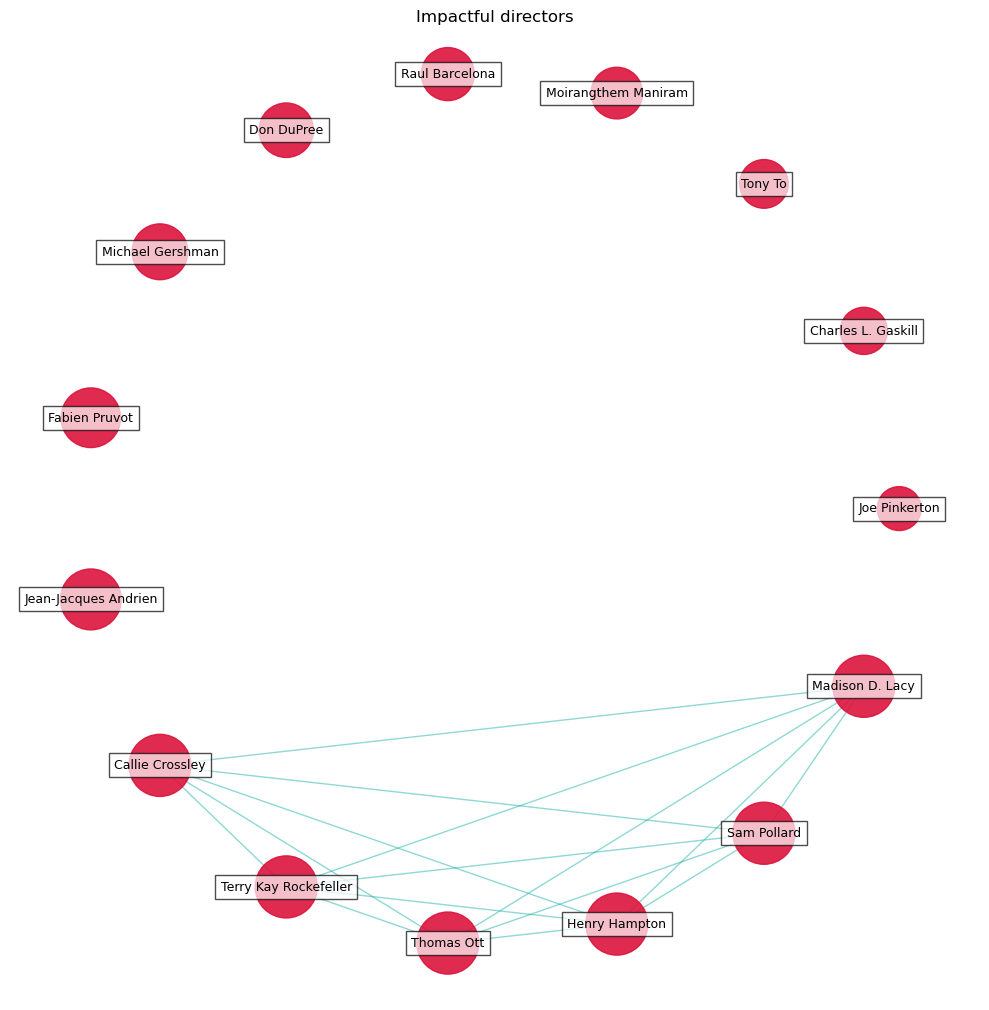

In [ ]:
# Generate layout for visualization
pos = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(10, 10))


# Visualize graph components
nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color='crimson', alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="lightseagreen") # width = weights

label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=18/20*10, bbox=label_options)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.title("Impactful directors")

#plt.savefig('../output/network_sparse.png', dpi = 500)
plt.show()


## Animated version

In [ ]:

# Create vis network
net = Network(notebook=True)
# Load the networkx graph
net.from_nx(G)
# Show
net.show("example.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Create function to generalise to all cases:

In [ ]:
import networkx as nx

In [ ]:
def draw_bubble_graph(df_score, df_pair_score, feature, genre, N):
    # df_score: dataframe with score of independent features
    # df_pair_score: dataframe with score of paired features
    # feature: string name of column in dataframe to process 'directors', 'actor_name', 'genre'
    # genre: movie genre subset to plot
    # N: number of feature points to include
    
    # Remove empty entries:
    df_score = df_score.drop(index=df_score[df_score[feature] == ''].index,axis=0)
    
    top_N = df_score.sort_values(by='Score')[0:N]
    ls_top = top_N[feature].tolist()
    df_pair_score = df_pair_score.rename({feature: feature +'_pair', 'Score':'Score_pair'}, axis = 1)

    # Create a merged dataframe where we have only collaborations which include top features
    df = top_N.merge(df_pair_score.rename({feature: feature +'_pair', 'Score':'Score_pair'}, axis = 1),how='left',left_on=feature, right_on= feature +'0')
    top_N_graph = df[df[feature +'1'].isin(df[feature])]
    #del df

    # Contains only top collaboration
    top_N_graph.head()
    
    # Complete with top individuals without collaboration
    top_N_graph = top_N.merge(top_N_graph,how='left',on=[feature,'Score'])
    top_N_graph.sample(5)
    
    # Create network graph: 
    
    #graph esthetic parameters
    max_node_size = 1000
    max_edge_width = 100

    # normalize scores and define their width in the graph
    nodes_scores = top_N_graph.drop_duplicates(subset=feature)['Score']
    nodes_size = np.array(nodes_scores)
    nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
    nodes_size *= max_node_size

    #Rescale edge weights: 
    weights = top_N_graph['Score_pair'].dropna()
    weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
    #weights *= max_edge_width
    top_N_graph['weight_edge'] = weights

    # Create edge data:
    edge_data = pd.DataFrame({'source' : top_N_graph[feature].tolist(),
                          'target' : top_N_graph[feature +'1'].tolist(),
                          'weight' : top_N_graph['weight_edge'].tolist()})

    # Create node data:
    node_data = pd.DataFrame({'name' : top_N_graph[feature].tolist(),
                          'score': top_N_graph['Score'].tolist()}).drop_duplicates(subset='name')


    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
    # Remove edges to NaN
    G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))
    # Remove node NaN
    if np.nan in G:
        G.remove_node(np.nan)
            

    # Generate layout for visualization
    pos = nx.circular_layout(G)
    fig, ax = plt.subplots(figsize=(10, 10))


    # Visualize graph components
    nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color='crimson', alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="lightseagreen") # width = weights

    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    nx.draw_networkx_labels(G, pos, font_size=18/20*10, bbox=label_options)

    # Resize figure for label readibility
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.title("Impactful " + feature)

    #plt.savefig('../output/network_sparse.png', dpi = 500)
    plt.show()



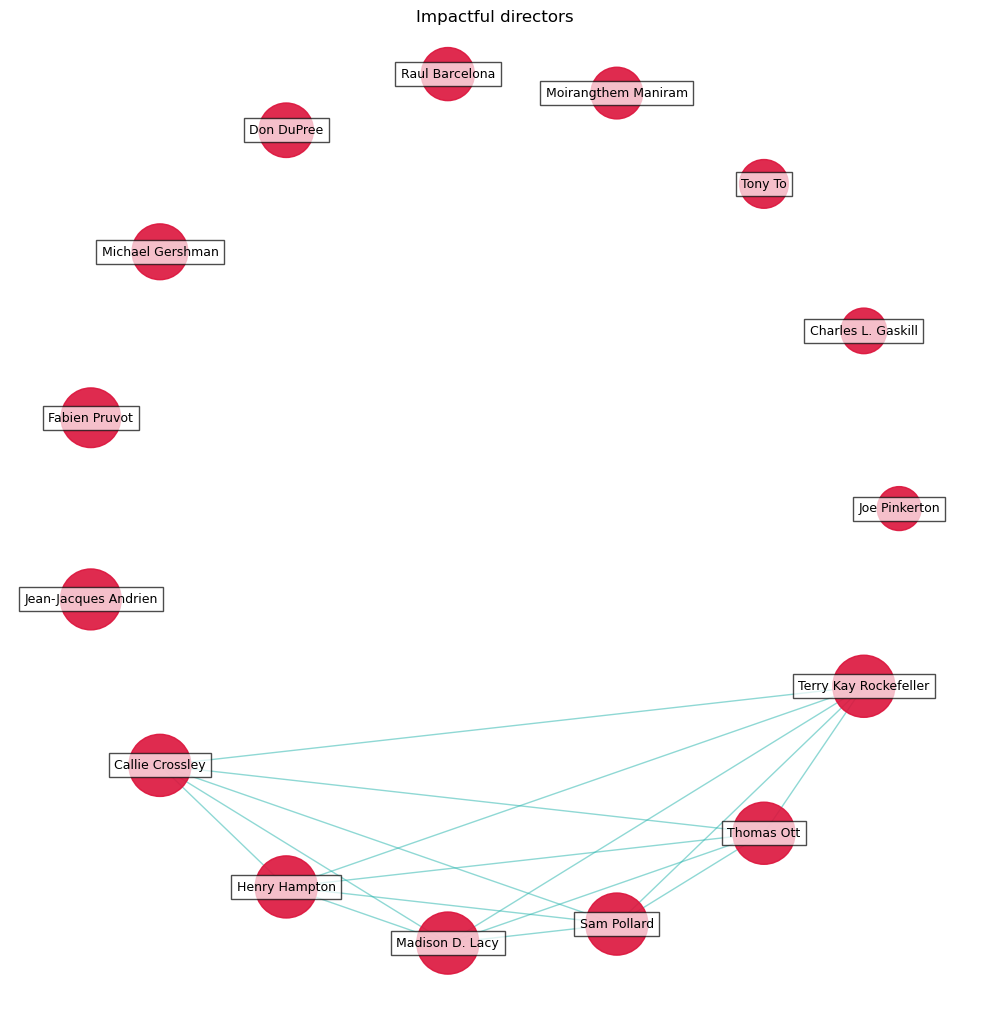

In [ ]:
draw_bubble_graph(directors_score ,director_pairs_score, 'directors', 'a', 15)

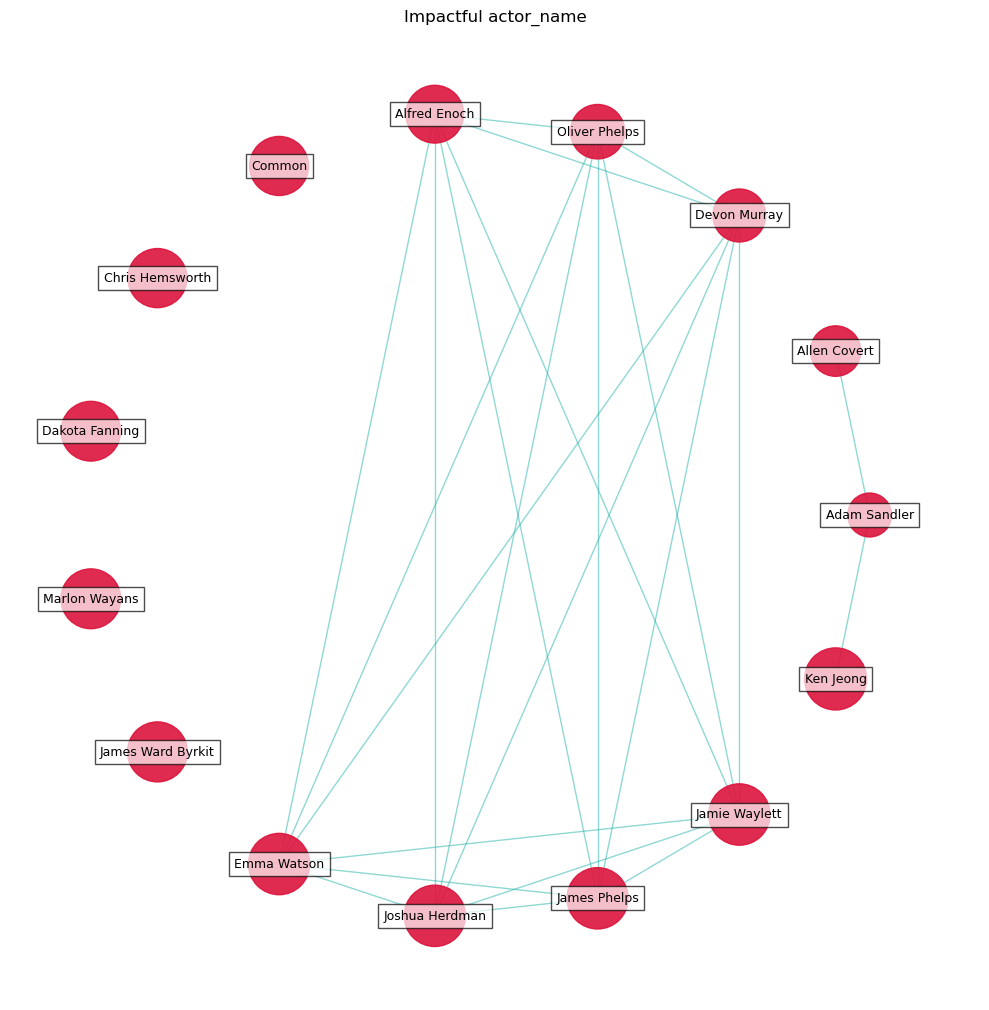

In [ ]:
draw_bubble_graph(actors_score ,actor_pairs_score, 'actor_name', 'a', 15)

ValueError: s must be a scalar, or float array-like with the same size as x and y

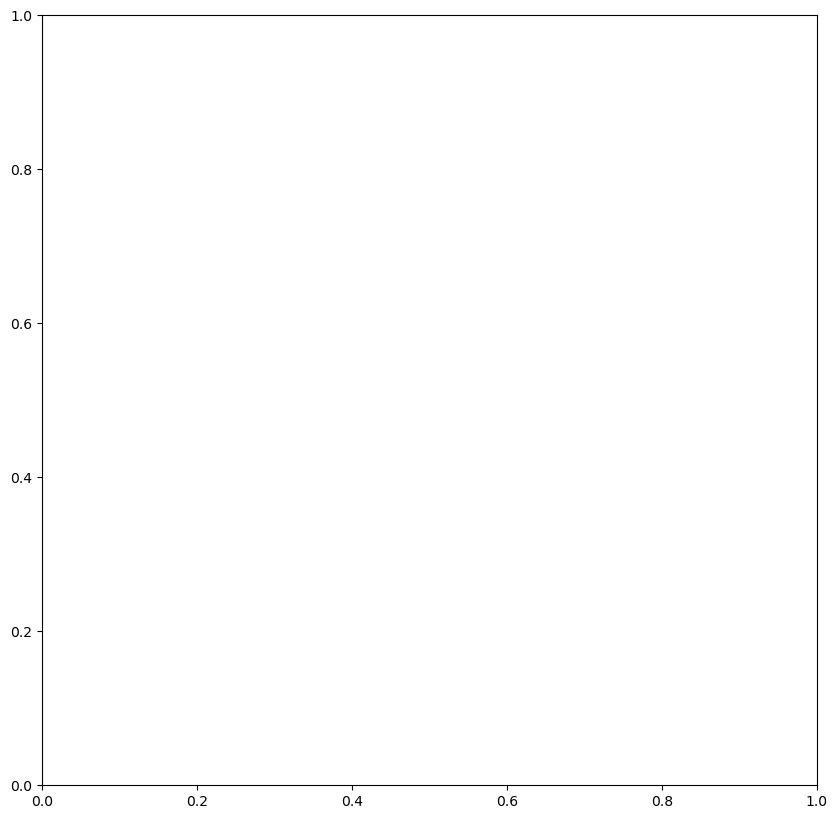

In [ ]:
draw_bubble_graph(genre_score ,genre_pairs_score, 'genre', 'insertgenre', 15)

In [ ]:
df_score=genre_score 
df_pair_score = genre_pairs_score
feature = 'genre'
N=15

In [ ]:
    # Remove empty entries:
    df_score = df_score.drop(index=df_score[df_score[feature] == ''].index,axis=0)
    
    top_N = df_score.sort_values(by='Score')[0:N]
    ls_top = top_N[feature].tolist()
    df_pair_score = df_pair_score.rename({feature: feature +'_pair', 'Score':'Score_pair'}, axis = 1)

    # Create a merged dataframe where we have only collaborations which include top features
    df = top_N.merge(df_pair_score.rename({feature: feature +'_pair', 'Score':'Score_pair'}, axis = 1),how='left',left_on=feature, right_on= feature +'0')
    top_N_graph = df[df[feature +'1'].isin(df[feature])]
    #del df

    # Contains only top collaboration
    top_N_graph.head()
    
    # Complete with top individuals without collaboration
    top_N_graph = top_N.merge(top_N_graph,how='left',on=[feature,'Score'])
    top_N_graph.sample(5)
    
    # Create network graph: 
    
    #graph esthetic parameters
    max_node_size = 1000
    max_edge_width = 100

    # normalize scores and define their width in the graph
    nodes_scores = top_N_graph.drop_duplicates(subset=feature)['Score']
    nodes_size = np.array(nodes_scores)
    nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
    nodes_size *= max_node_size

    #Rescale edge weights: 
    weights = top_N_graph['Score_pair'].dropna()
    weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
    #weights *= max_edge_width
    top_N_graph['weight_edge'] = weights

    # Create edge data:
    edge_data = pd.DataFrame({'source' : top_N_graph[feature].tolist(),
                          'target' : top_N_graph[feature +'1'].tolist(),
                          'weight' : top_N_graph['weight_edge'].tolist()})

    # Create node data:
    node_data = pd.DataFrame({'name' : top_N_graph[feature].tolist(),
                          'score': top_N_graph['Score'].tolist()}).drop_duplicates(subset='name')


    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
    # Remove edges to NaN
    G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))
    # Remove node NaN
    if np.nan in G:
        G.remove_node(np.nan)
            


In [ ]:
node_data

,name,score
0,Revisionist Fairy Tale,553.500000
1,Plague,858.400000
2,Space opera,966.200000
3,Private military company,995.000000
4,Outlaw,1009.800000
5,Expressionism,1949.000000
6,Humour,2113.250000
7,Silhouette animation,2274.000000
8,Demonic child,2371.166667
9,Vampire movies,2512.000000


In [ ]:
edge_data

,source,target,weight
0,Revisionist Fairy Tale,NaN,NaN
1,Plague,NaN,NaN
2,Space opera,NaN,NaN
3,Private military company,NaN,NaN
4,Outlaw,NaN,NaN
5,Expressionism,NaN,NaN
6,Humour,NaN,NaN
7,Silhouette animation,NaN,NaN
8,Demonic child,NaN,NaN
9,Vampire movies,NaN,NaN


In [ ]:
top_N_graph

,genre,count_x,Score,count_y,genre_pair,num_movies,Score_pair,genre0,genre1,weight_edge
0,Revisionist Fairy Tale,2,553.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Plague,5,858.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Space opera,5,966.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Private military company,2,995.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Outlaw,5,1009.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Expressionism,3,1949.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Humour,4,2113.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Silhouette animation,1,2274.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Demonic child,6,2371.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Vampire movies,3,2512.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: s must be a scalar, or float array-like with the same size as x and y

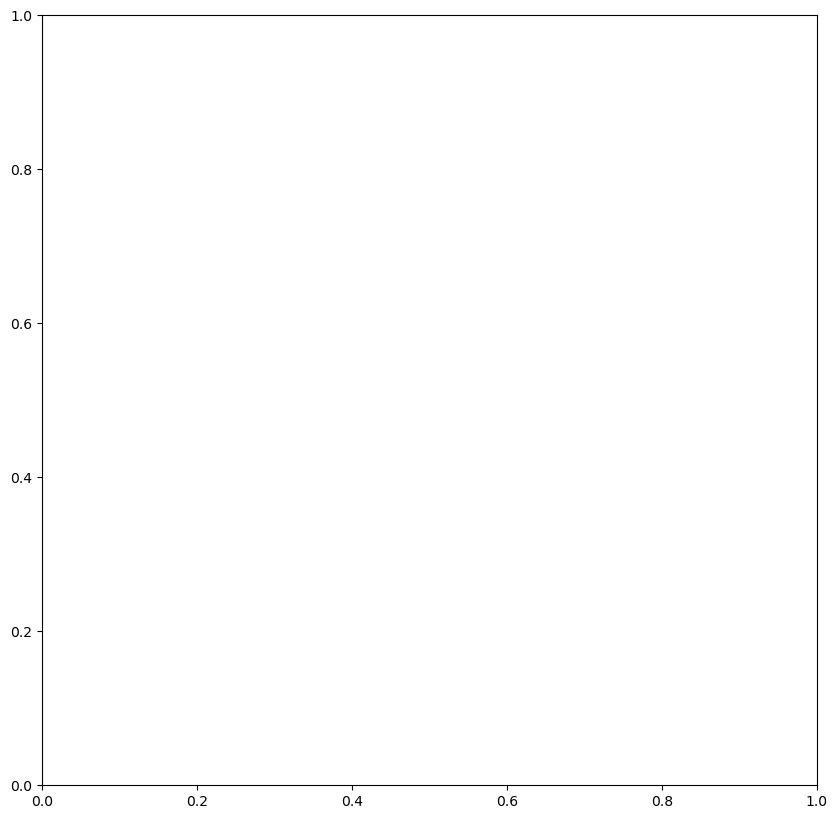

In [ ]:

    # Generate layout for visualization
    pos = nx.circular_layout(G)
    fig, ax = plt.subplots(figsize=(10, 10))


    # Visualize graph components
    nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color='crimson', alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="lightseagreen") # width = weights

    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    nx.draw_networkx_labels(G, pos, font_size=18/20*10, bbox=label_options)

    # Resize figure for label readibility
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.title("Impactful " + feature)

    #plt.savefig('../output/network_sparse.png', dpi = 500)
    plt.show()


